#INFO

- This notebook is for U-Net with 4x4 blocks and minimized layers.
- This notebook is for fine-tuning the model.
- Losses to be tested: IOU, Dice Loss, Combined Losses.
- Optimizers: Adam, SGD.
- Iterator: Grid Search.


**Moutning google drive**

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##imports

In [10]:
import pandas as pd
import numpy as np


dir = "/content/drive/MyDrive/Colab Notebooks FINAL/data_prepare/training_data"

IMAGES = np.load(f'{dir}/IMAGES.npy', allow_pickle=True)
MASKS = np.load(f'{dir}/MASKS.npy', allow_pickle=True)

print(IMAGES.shape)
print(MASKS.shape)

(3032, 256, 256, 1)
(3032, 256, 256, 1)


In [11]:
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D, concatenate
from keras.layers import  Dropout, Activation
from keras.optimizers import Adam, SGD
from keras.layers import LeakyReLU,Add
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from keras.utils import plot_model
import tensorflow as tf
import glob
import random
import cv2
from random import shuffle
from tensorflow.keras.metrics import BinaryAccuracy, Precision, MeanIoU, Recall, AUC
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import math
import seaborn as sns
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

#losses and optimizers

##**Metrics**

Mean IOU

In [12]:
def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

In [ ]:
"""def iou_coef2(y_true, y_pred):
  smooth = K.epsilon() ##
  thr = 0.5 ###
  y_pred = K.cast(K.greater(y_pred, .5), dtype='float32') # apply threshold to prediction
  intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
  union = K.sum(y_true,-1) + K.sum(y_pred,-1) - intersection
  return K.mean((intersection + smooth) / (union + smooth), axis=0)"""

Pixel accuracy

In [13]:
def pixel_accuracy(y_true, y_pred):
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.round(tf.reshape(y_pred, [-1]))  # round to get 0 or 1 prediction
    
    correct_pixels = tf.reduce_sum(tf.cast(tf.equal(y_true_f, y_pred_f), tf.float32))
    total_pixels = tf.cast(tf.size(y_true_f), tf.float32)
    
    return correct_pixels / total_pixels

Pescision and Recall

In [14]:
def recall(y_true, y_pred):
  smooth = K.epsilon() ##
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  recall = true_positives / (possible_positives + smooth)
  return recall

def precision(y_true, y_pred):
  smooth = K.epsilon() ##
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
  precision = true_positives / (predicted_positives + smooth)
  return precision

F1 score

In [15]:
def f1(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    
    # Ensure the F1 score is defined even when precision and recall are 0
    if p + r == 0:
        return 0.0

    f1 = 2 * ((p * r) / (p + r))
    return f1

In [16]:
metrics = [iou_coef,
           pixel_accuracy,
           recall,
           precision,
           f1]

##**Loss**

especially with class imbalance (which is common in biomedical imaging where the region of interest is often small compared to the entire image), the Dice loss alone may not be the best choice, as it can be biased towards the majority class. 
source : chatgpt

**Dice Loss**

In [17]:
def dice_coef(y_true, y_pred, smooth=.1):

    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(K.abs(y_true * y_pred))
    return (2. * intersection) / (K.sum(K.square(y_true)) + K.sum(K.square(y_pred)) + smooth)

def dice_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)


In [18]:
def dice_loss_inv(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


**IOU loss**

In [19]:
def iou_loss(y_true, y_pred):
    return 1 - iou_coef(y_true, y_pred)

**focal loss**

In [20]:
def focal_loss(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    BCE = K.binary_crossentropy(y_true_f, y_pred_f)
    BCE_EXP = K.exp(-BCE)
    focal_loss = K.mean(0.8 * K.pow((1-BCE_EXP), 2.) * BCE)
    return focal_loss

**combind losses**

In [41]:
#dice coeff and iou coeff loss combind
def c_loss(y_true, y_pred):
  return -(0.4*dice_coef(y_true, y_pred)+0.6*iou_coef(y_true, y_pred))

##**Optimizers**

**Adam**

In [23]:
def Adam_opt(lr = 0.0001):
  
  optimizer = tf.keras.optimizers.Adam(
    name= "adamOPT",
    learning_rate=lr,
    #decay=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07
  )
  return optimizer

def lr_schedule(initial = 0.001):
  initial_learning_rate = 0.001
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, 
                                                               decay_steps=1000, 
                                                               decay_rate=0.96, staircase=True
                                                                )
  return lr_schedule

**SGD**

In [24]:
def SGD_opt(lr = 0.0001):
  opt = tf.keras.optimizers.SGD(name = "SGDOpt",learning_rate=0.001, momentum=0.9)
  return opt

**RMSprop**

In [25]:
def RMSprop_opt(lr = 0.0001):
  opt = tf.keras.optimizers.RMSprop(name = "RMSPropOpt",learning_rate=0.001)
  return opt

##**callbacks**

In [26]:
def build_callbacks(model_name, patience = 10): 
    callback= [ModelCheckpoint(f'/content/drive/MyDrive/trained_models/U-Net/{model_name}.h5',verbose =1, save_best_only=True),
    EarlyStopping(patience = patience, verbose =1, restore_best_weights=True ,monitor = "val_loss")]
    return callback

#Model architicture

In [27]:
def down_block(input,start_neurons):
    conv = Conv2D(start_neurons, (3, 3), activation='relu', padding='same')(input)
    conv = BatchNormalization()(conv)
    conv = Conv2D(start_neurons, (3, 3), activation='relu', padding='same')(conv)
    conv = BatchNormalization()(conv)
    pool = MaxPooling2D(pool_size=(2, 2))(conv)

    return conv , pool


def up_block(input,skip_features,start_neurons):
    up = concatenate([Conv2DTranspose(start_neurons, (2, 2), strides=(2, 2), padding='same')(input), skip_features], axis=3)
    conv = Conv2D(start_neurons , (3, 3), activation='relu', padding='same')(up)
    conv = BatchNormalization()(conv)
    conv = Conv2D(start_neurons , (3, 3), activation='relu', padding='same')(conv)
    conv = BatchNormalization()(conv)

    return conv


def aspp_block(x, num_filters, rate_scale=1):
    x1 = Conv2D(num_filters, (3, 3), dilation_rate=(6 * rate_scale, 6 * rate_scale), padding="same")(x)
    x1 = BatchNormalization()(x1)

    x2 = Conv2D(num_filters, (3, 3), dilation_rate=(12 * rate_scale, 12 * rate_scale), padding="same")(x)
    x2 = BatchNormalization()(x2)

    x3 = Conv2D(num_filters, (3, 3), dilation_rate=(18 * rate_scale, 18 * rate_scale), padding="same")(x)
    x3 = BatchNormalization()(x3)

    x4 = Conv2D(num_filters, (3, 3), padding="same")(x)
    x4 = BatchNormalization()(x4)

    y = Add()([x1, x2, x3, x4])
    y = Conv2D(num_filters, (1, 1), padding="same")(y)

    return y



def unet(input_size = (256,256,1) , start_neurons = 16):

    inputs = Input(input_size)
    #downblocks
    conv1 , pool1 = down_block(inputs, start_neurons * 1)
    conv2 , pool2 = down_block(pool1, start_neurons * 2)
    conv3 , pool3 = down_block(pool2, start_neurons * 4)
    conv4 , pool4 = down_block(pool3, start_neurons * 8) 


    #middle (we don't need pool in the middle)
    mconv = aspp_block(pool4, start_neurons * 16)
    #mconv, _ = down_block(pool4 , start_neurons * 16)

    #upblocks
    uconv4 = up_block(mconv , conv4 , start_neurons * 8)
    uconv3 = up_block(uconv4, conv3 , start_neurons * 4)
    uconv2 = up_block(uconv3 , conv2 , start_neurons * 2)
    uconv1 = up_block(uconv2 , conv1 , start_neurons * 1)

    output_layer = Conv2D(1, (1, 1), activation='sigmoid')(uconv1)

    model = Model(inputs=[inputs], outputs=[output_layer])

    return model

In [28]:
model = unet()

In [29]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [30]:
!pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


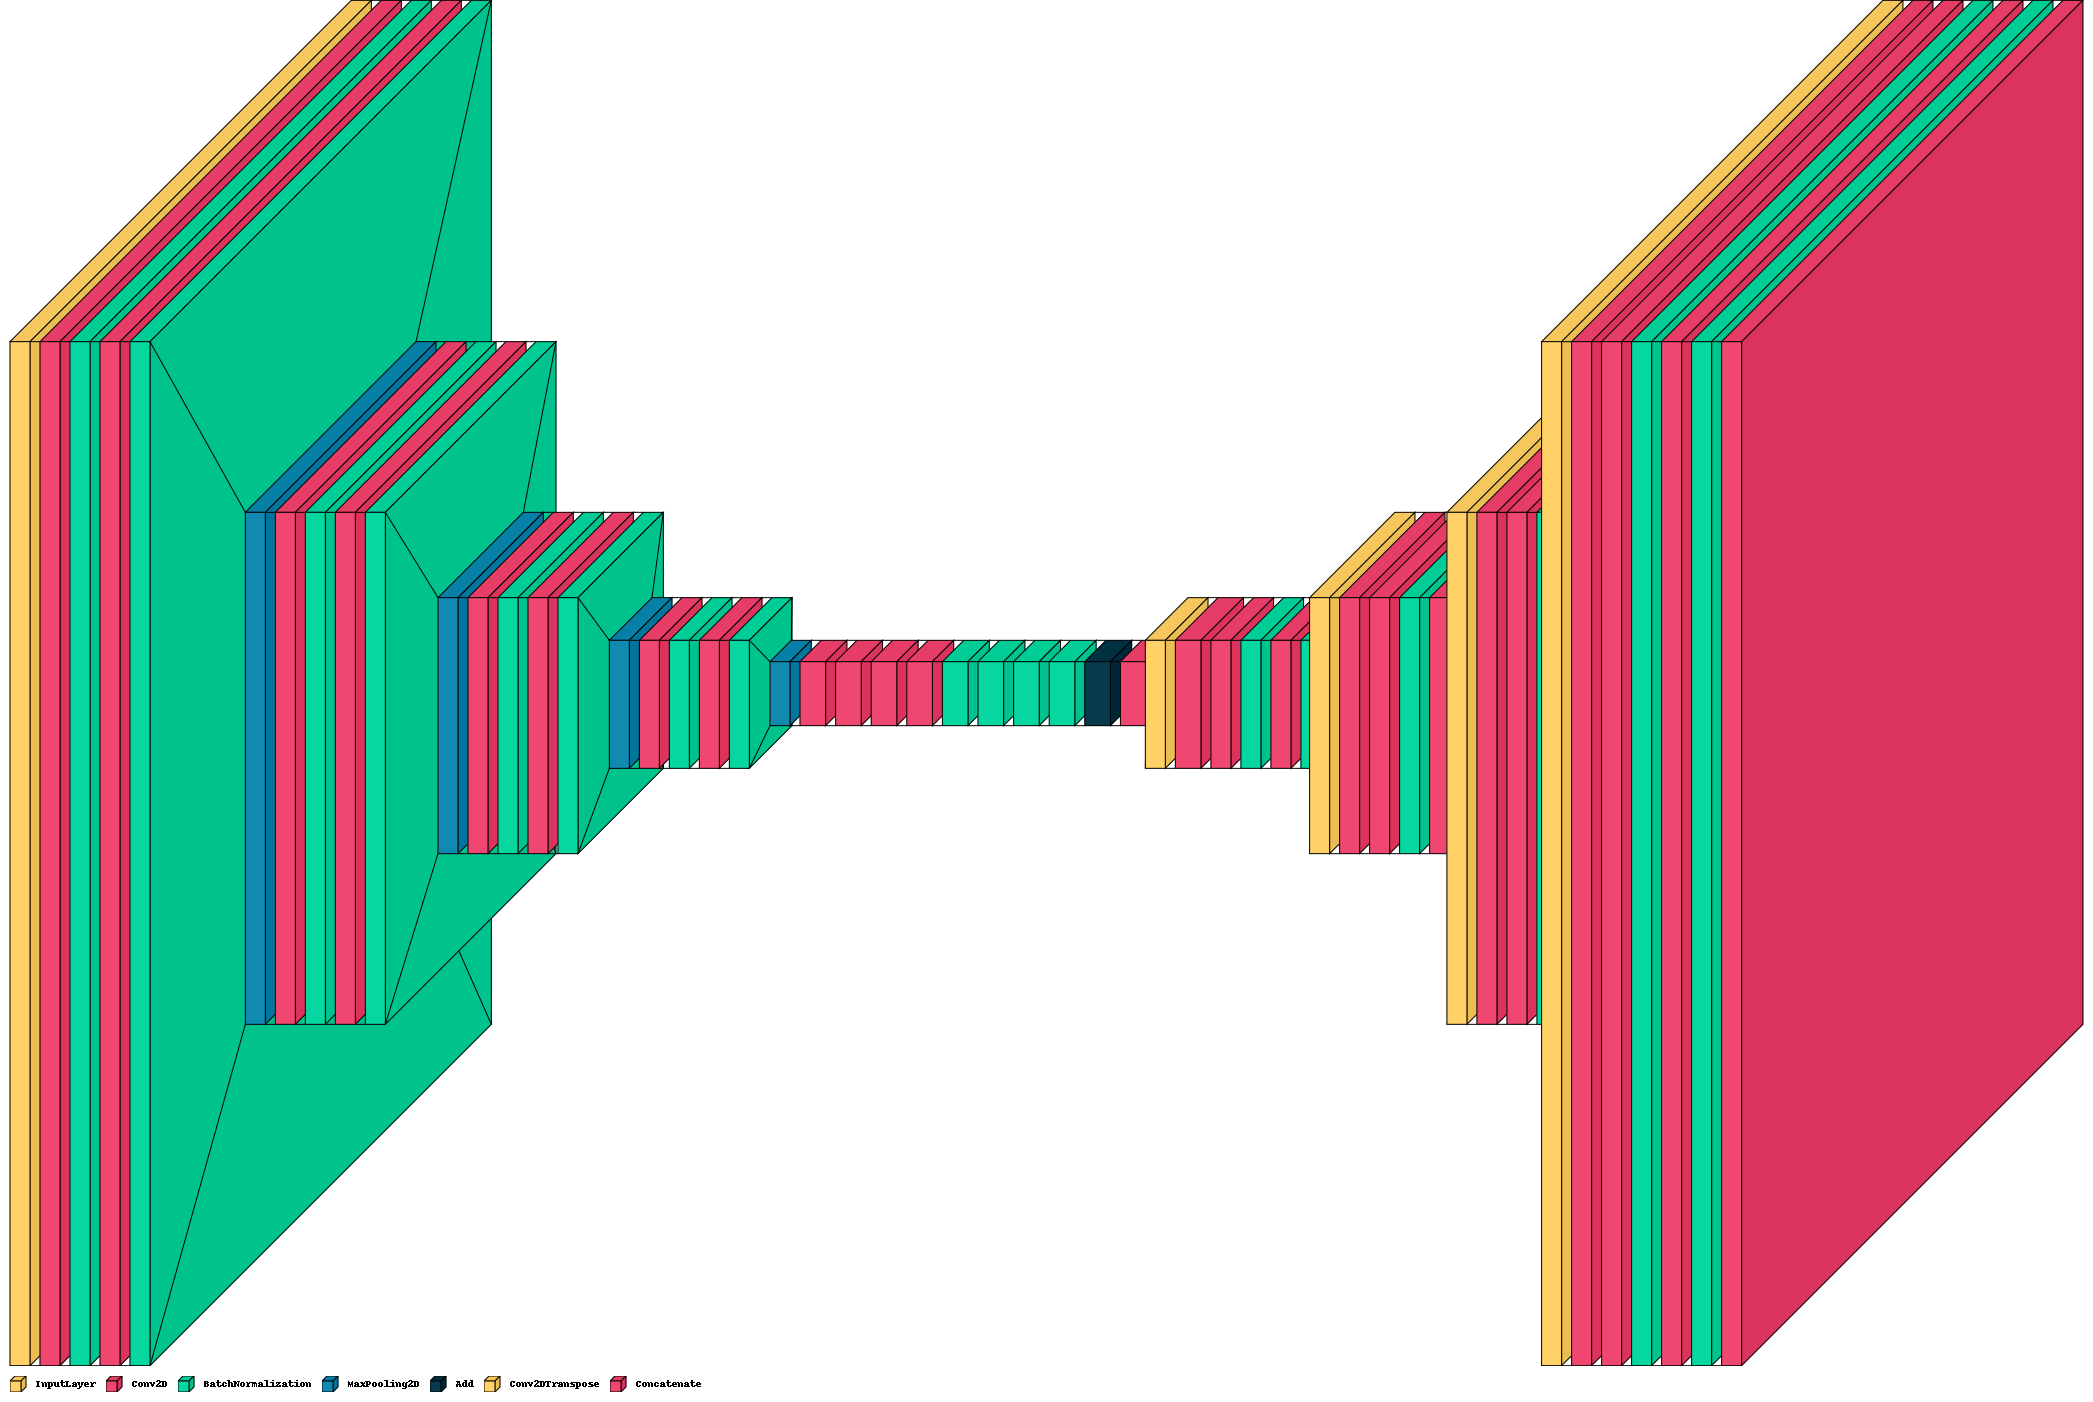

In [31]:
import visualkeras
visualkeras.layered_view(model,legend=True, draw_volume=True)

#**Fitting**

##functions

defining a function to train the model of which some parameters we can change

In [43]:
def split_data(d_divisor = 1 , test_size = 0.2 , val_size = 0.2):
  #decrease the data by a divisor
  IMAGES_sub = np.split(IMAGES, d_divisor)[0] 
  MASKS_sub = np.split(MASKS, d_divisor)[0] 

  # Split dataset into train and test sets (80/20 split)
  x_train, x_val , y_train, y_val = train_test_split(IMAGES_sub, MASKS_sub, test_size=test_size, random_state=42)

  # Split training set into train and validation sets (80/20 split) # 0.05
  x_train, x_test, y_train, y_test  = train_test_split(x_train, y_train, test_size=val_size, random_state=42)

  # the model needs the mask to be floating point
  y_train = y_train.astype('float32')
  y_val = y_val.astype('float32')

  return x_train , y_train , x_test , y_test , x_val , y_val

**Function to plot the history**

In [44]:
def plot_history(history, model_name):
    sns.set(style="darkgrid")
    
    # Get all metrics that do not start with 'val_'
    metrics = [key for key in history.history.keys() if not key.startswith('val_')]
    num_metrics = len(metrics)
    num_cols = 3
    num_rows = math.ceil(num_metrics / num_cols)

    fig = plt.figure(figsize=(15, 5 * num_rows))

    fig.suptitle(f'{model_name} History' , fontsize=14 , fontweight='bold', ha='center')
    
    for i, metric in enumerate(metrics):
        plt.subplot(num_rows, num_cols, i+1)
        
        train_line = plt.plot(history.history[metric], label='Train', color='navy')
        if 'val_'+metric in history.history.keys():
            validation_line = plt.plot(history.history['val_'+metric], label='Validation', color='darkorange')
        
        plt.title('Model ' + metric, fontsize=14)
        plt.ylabel(metric, fontsize=12)
        plt.xlabel('Epoch', fontsize=12)
        plt.legend(loc='upper left')
        plt.grid(True)

    # Adjust spacing between subplots and show plot
    plt.tight_layout()
    plt.show()

function to plot a random sample

In [45]:
def plot_image(img):
  plt.imshow(img.reshape(128,128), interpolation='nearest')
  plt.show()
  return plt

def plot_prediction(model_name, y_pred, x_test, num_samples=3):
    # Choose random indices
    indices = np.random.choice(np.arange(y_pred.shape[0]), size=num_samples, replace=False)

    fig, axs = plt.subplots(num_samples, 4, figsize=(16, 4*num_samples))
    fig.suptitle(f'{model_name} Prediction', fontsize=16, fontweight='bold', ha='center')

    for i, idx in enumerate(indices):
        # Get data
        x = x_test[idx]
        true = y_test[idx]  # true mask
        pred = y_pred[idx]
        binary_pred = np.where(pred > 0.5, 1, 0)  # pred after post-processing

        # Plot original image
        axs[i, 0].imshow(x, cmap='gray')
        axs[i, 0].set_title("Original", fontsize=12)
        axs[i, 0].axis('off')

        # Plot prediction
        axs[i, 1].imshow(pred.squeeze(), cmap='gray')
        axs[i, 1].set_title("Predicted", fontsize=12)
        axs[i, 1].axis('off')

        # Plot binary prediction
        axs[i, 2].imshow(binary_pred.squeeze(), cmap='gray')
        axs[i, 2].set_title("Binary Predicted", fontsize=12)
        axs[i, 2].axis('off')

        # Plot ground truth
        axs[i, 3].imshow(true.squeeze(), cmap='gray')
        axs[i, 3].set_title("Ground Truth", fontsize=12)
        axs[i, 3].axis('off')

    plt.tight_layout()
    plt.show()


##testing different hyper parameters

iteratering over models will take much time therfore we will reduce the dataset by half , we will also perform a callback.
 - optimizers
 - losses

In [51]:
losses = [iou_loss, dice_loss , dice_loss_inv , c_loss]
losses_name = ["iouLoss" , "diceLoss" , "diceINVLoss" , "IouDiceLoss"]

##different losses

In [52]:
x_train , y_train , x_test , y_test , x_val , y_val =  split_data(2, test_size = 0.1 , val_size = 0.05)

In [53]:
histories = {}
models = {}

In [54]:
i = 0
for loss in losses:
        loss_name = losses_name[i]
        model = unet()
        model.compile(loss=loss, optimizer=Adam_opt(), metrics=metrics)
        model_name = 'unet_{}_{}'.format(loss_name, "Adam")

        print(f'#######Training model : {model_name}###########')

        history = model.fit(x_train, y_train,
                            validation_data=(x_test, y_test),
                            callbacks = build_callbacks(model_name),
                            epochs=100,
                            batch_size = 1,
                            verbose=0)
        
        histories[model_name] = history
        models[model_name] = model
        i = i+1

#######Training model : unet_iouLoss_Adam###########

Epoch 1: val_loss improved from inf to 0.95252, saving model to /content/drive/MyDrive/trained_models/U-Net/unet_iouLoss_Adam.h5

Epoch 2: val_loss improved from 0.95252 to 0.94326, saving model to /content/drive/MyDrive/trained_models/U-Net/unet_iouLoss_Adam.h5

Epoch 3: val_loss improved from 0.94326 to 0.91278, saving model to /content/drive/MyDrive/trained_models/U-Net/unet_iouLoss_Adam.h5

Epoch 4: val_loss did not improve from 0.91278

Epoch 5: val_loss improved from 0.91278 to 0.91010, saving model to /content/drive/MyDrive/trained_models/U-Net/unet_iouLoss_Adam.h5

Epoch 6: val_loss improved from 0.91010 to 0.89517, saving model to /content/drive/MyDrive/trained_models/U-Net/unet_iouLoss_Adam.h5

Epoch 7: val_loss improved from 0.89517 to 0.89185, saving model to /content/drive/MyDrive/trained_models/U-Net/unet_iouLoss_Adam.h5

Epoch 8: val_loss improved from 0.89185 to 0.87375, saving model to /content/drive/MyDrive/trained

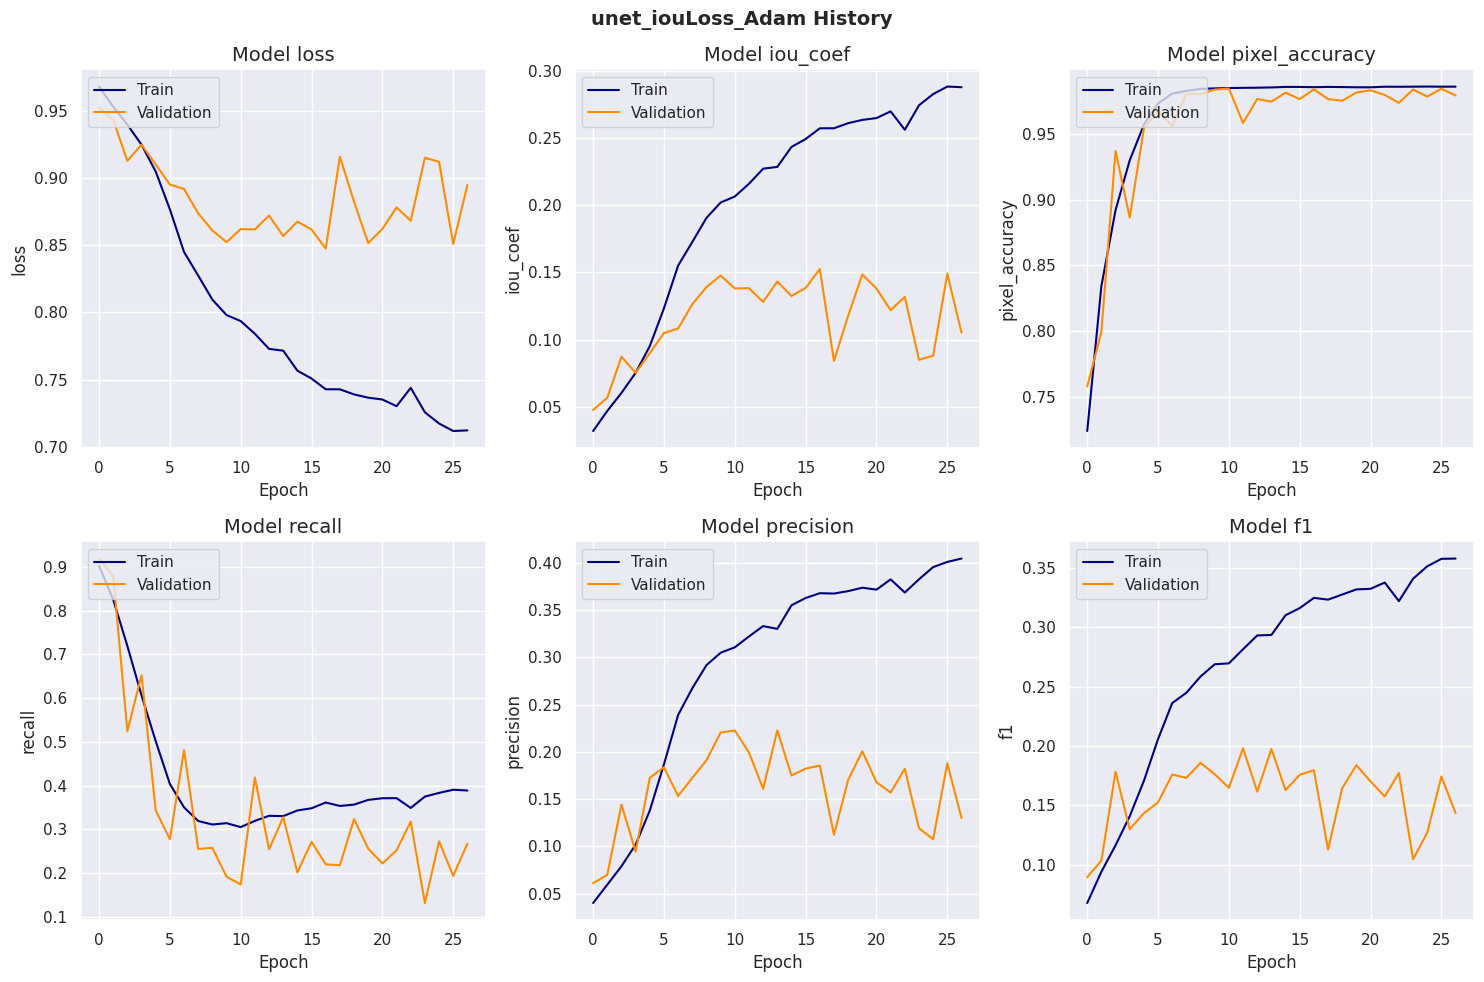

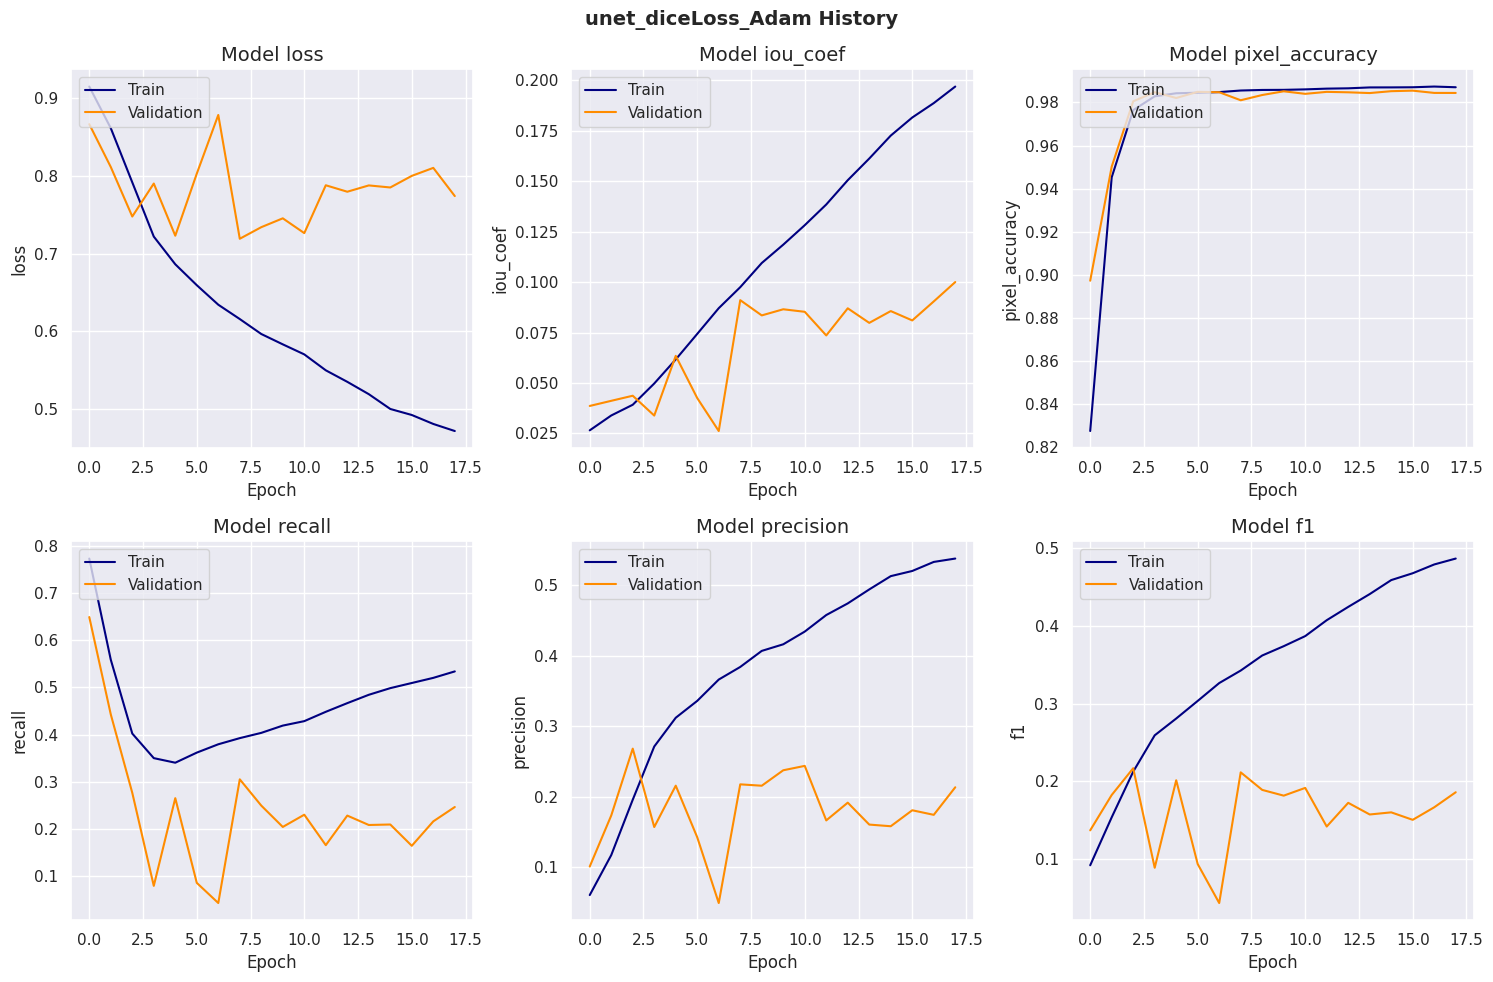

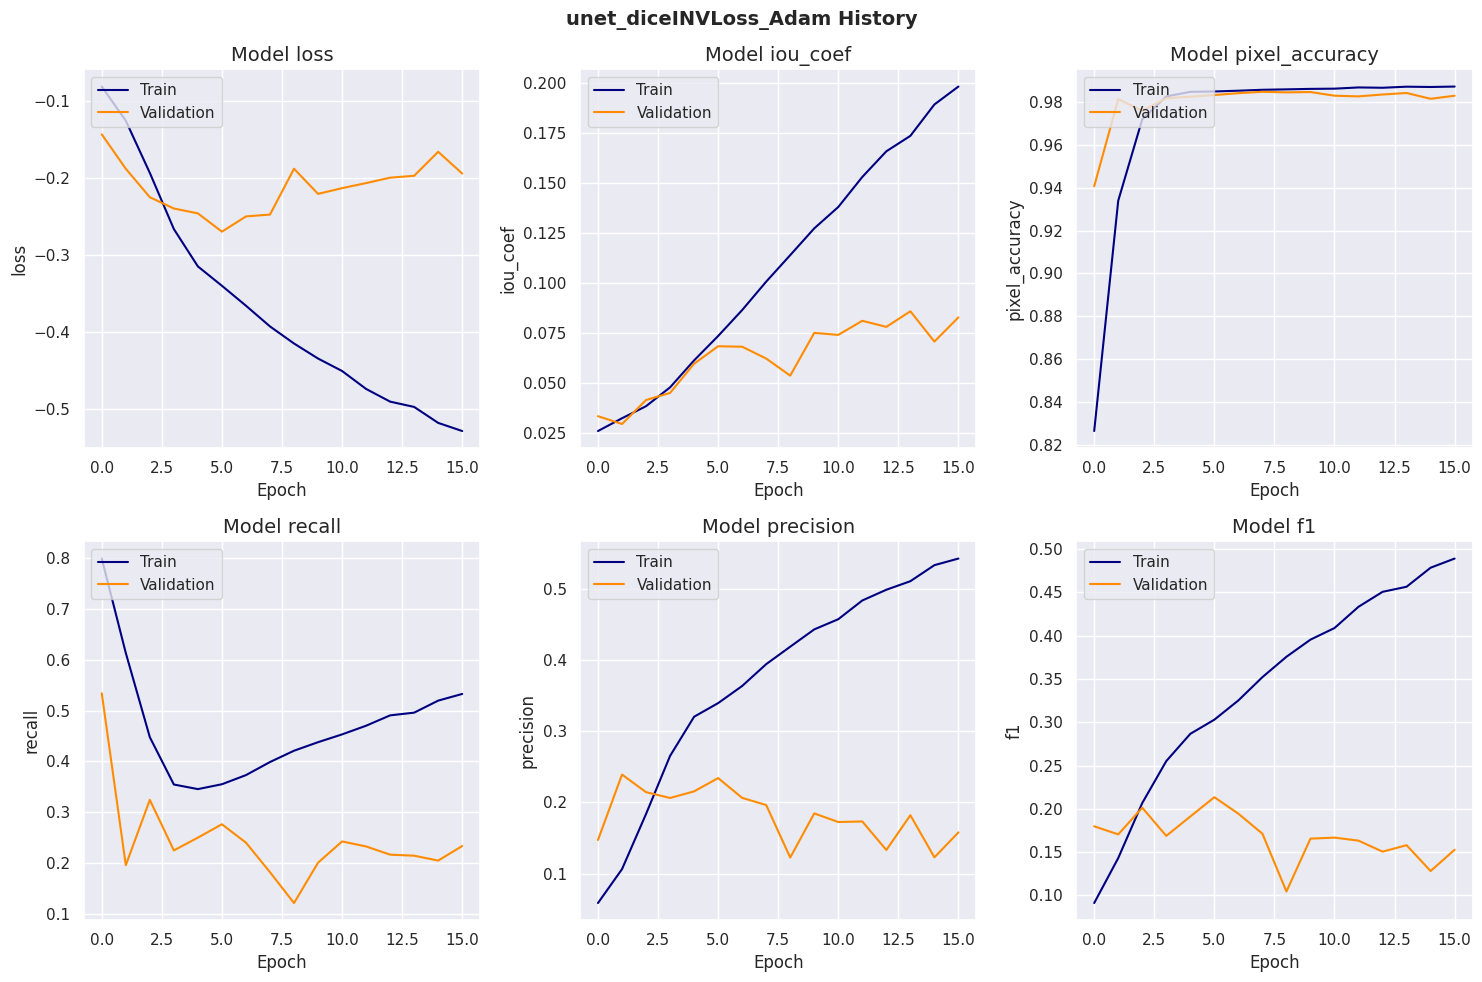

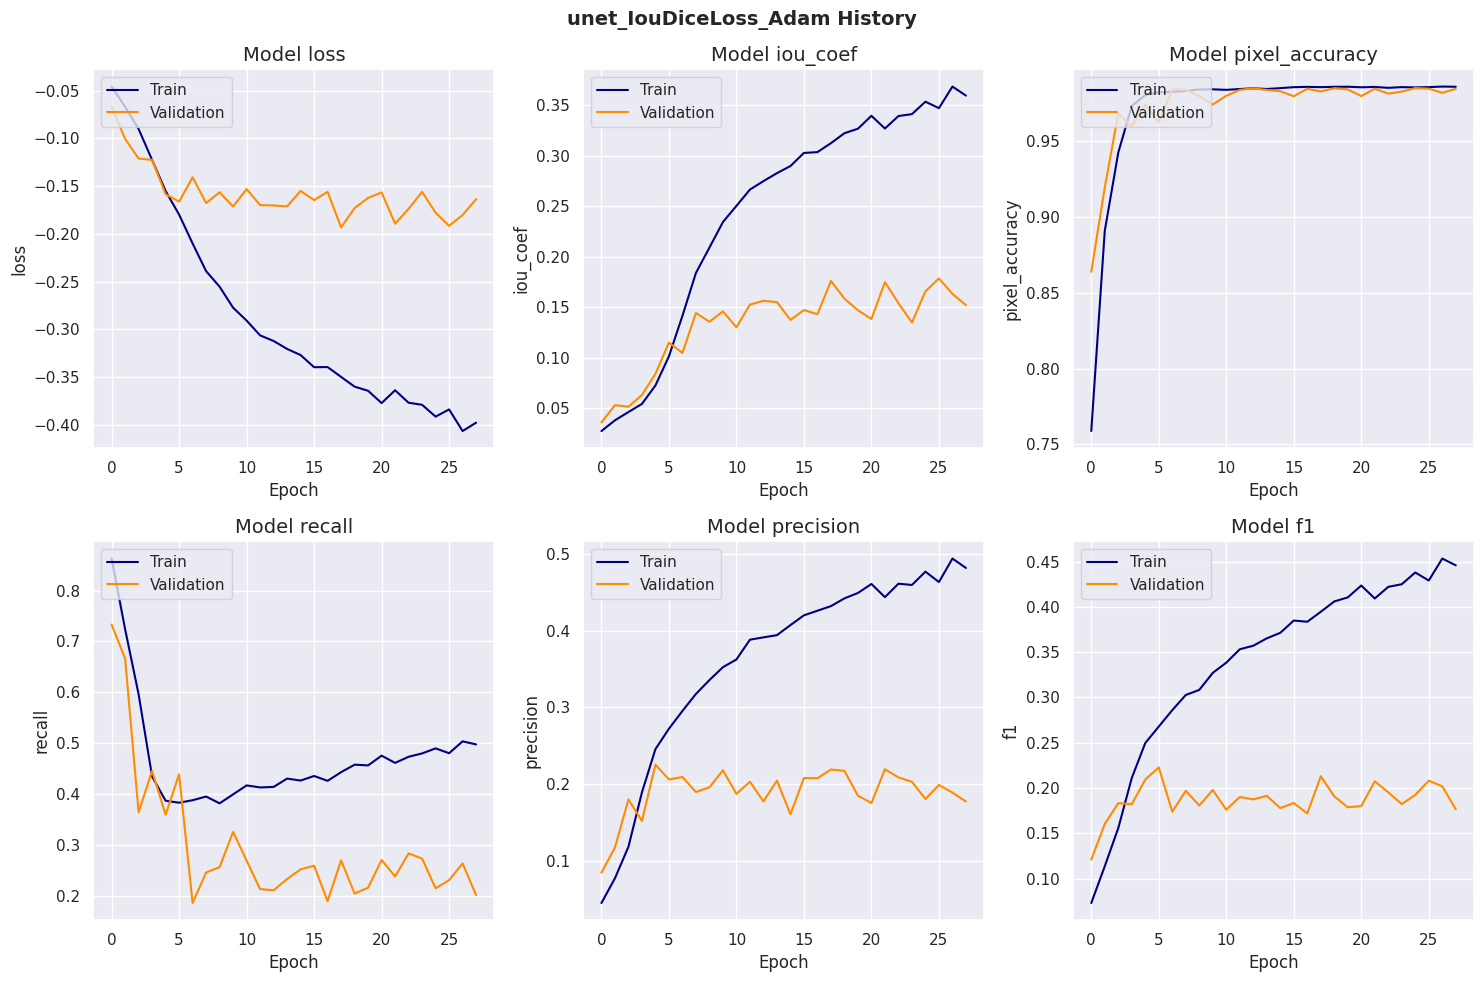

In [55]:
for model_name, history in histories.items():
    print(f'\n \n')
    plot_history(history, model_name)

3/3 [==============================] - 5s 567ms/step


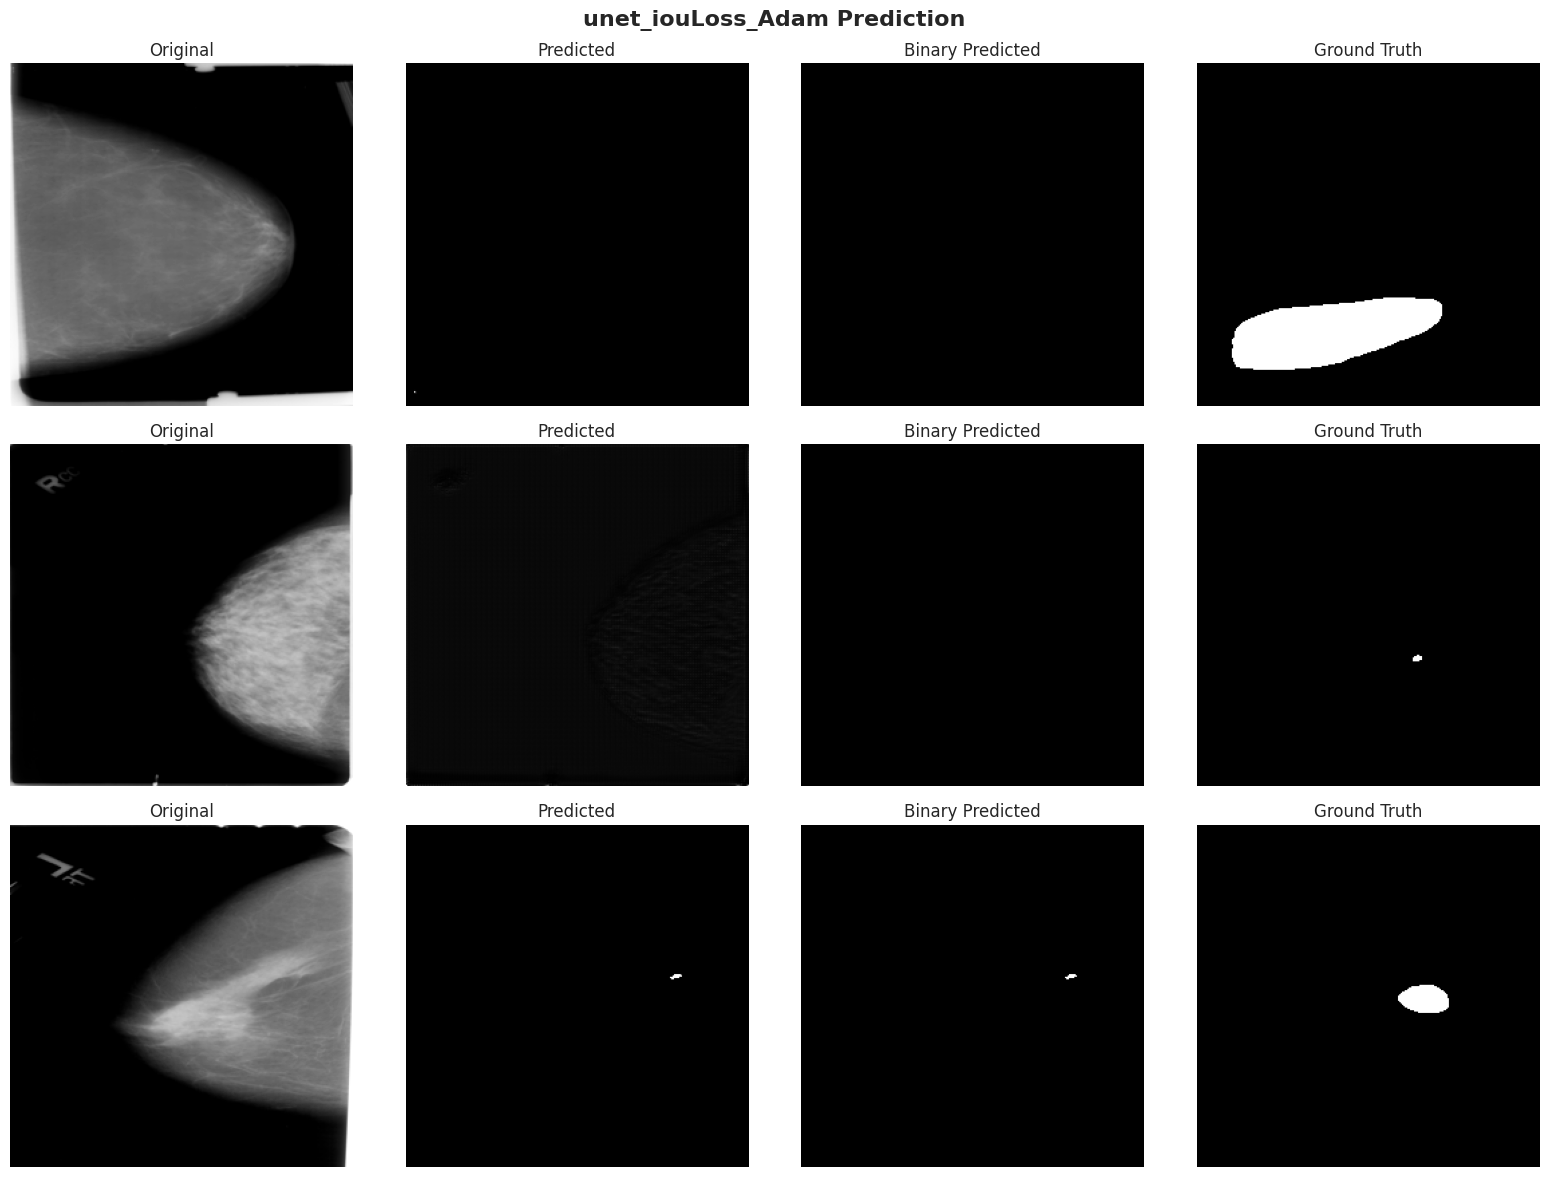

3/3 [==============================] - 1s 106ms/step


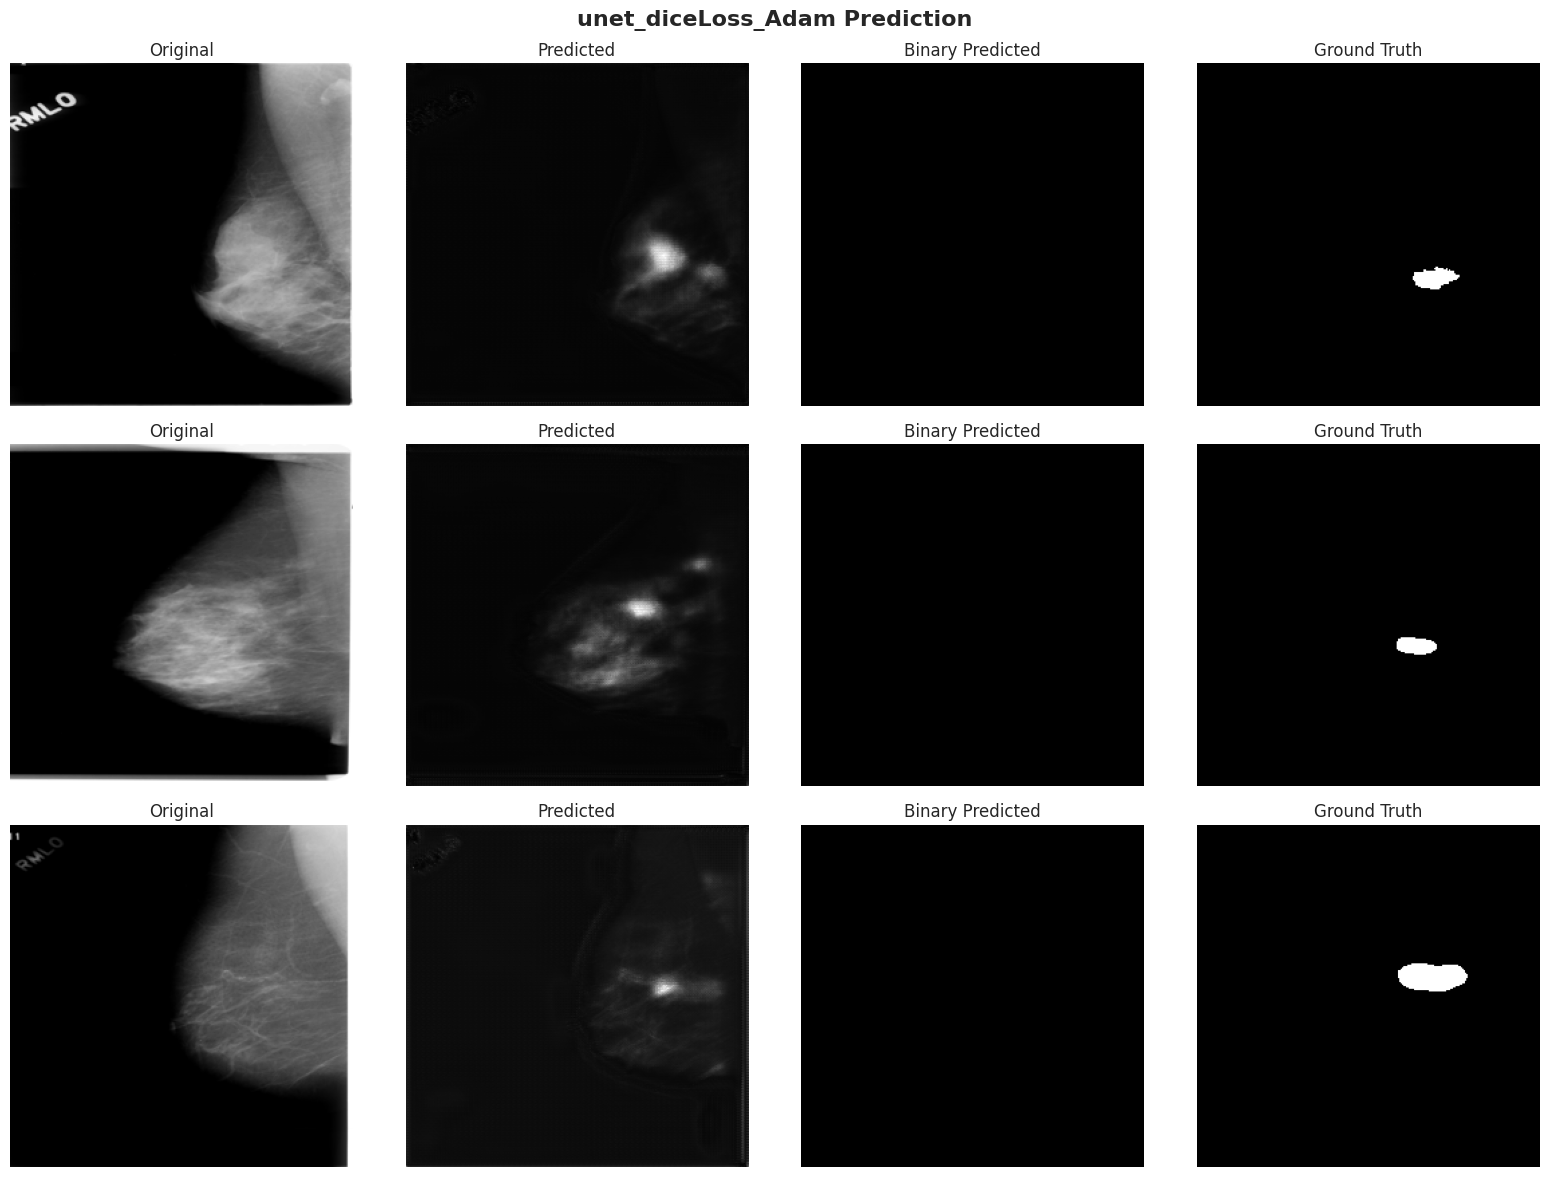

3/3 [==============================] - 1s 105ms/step


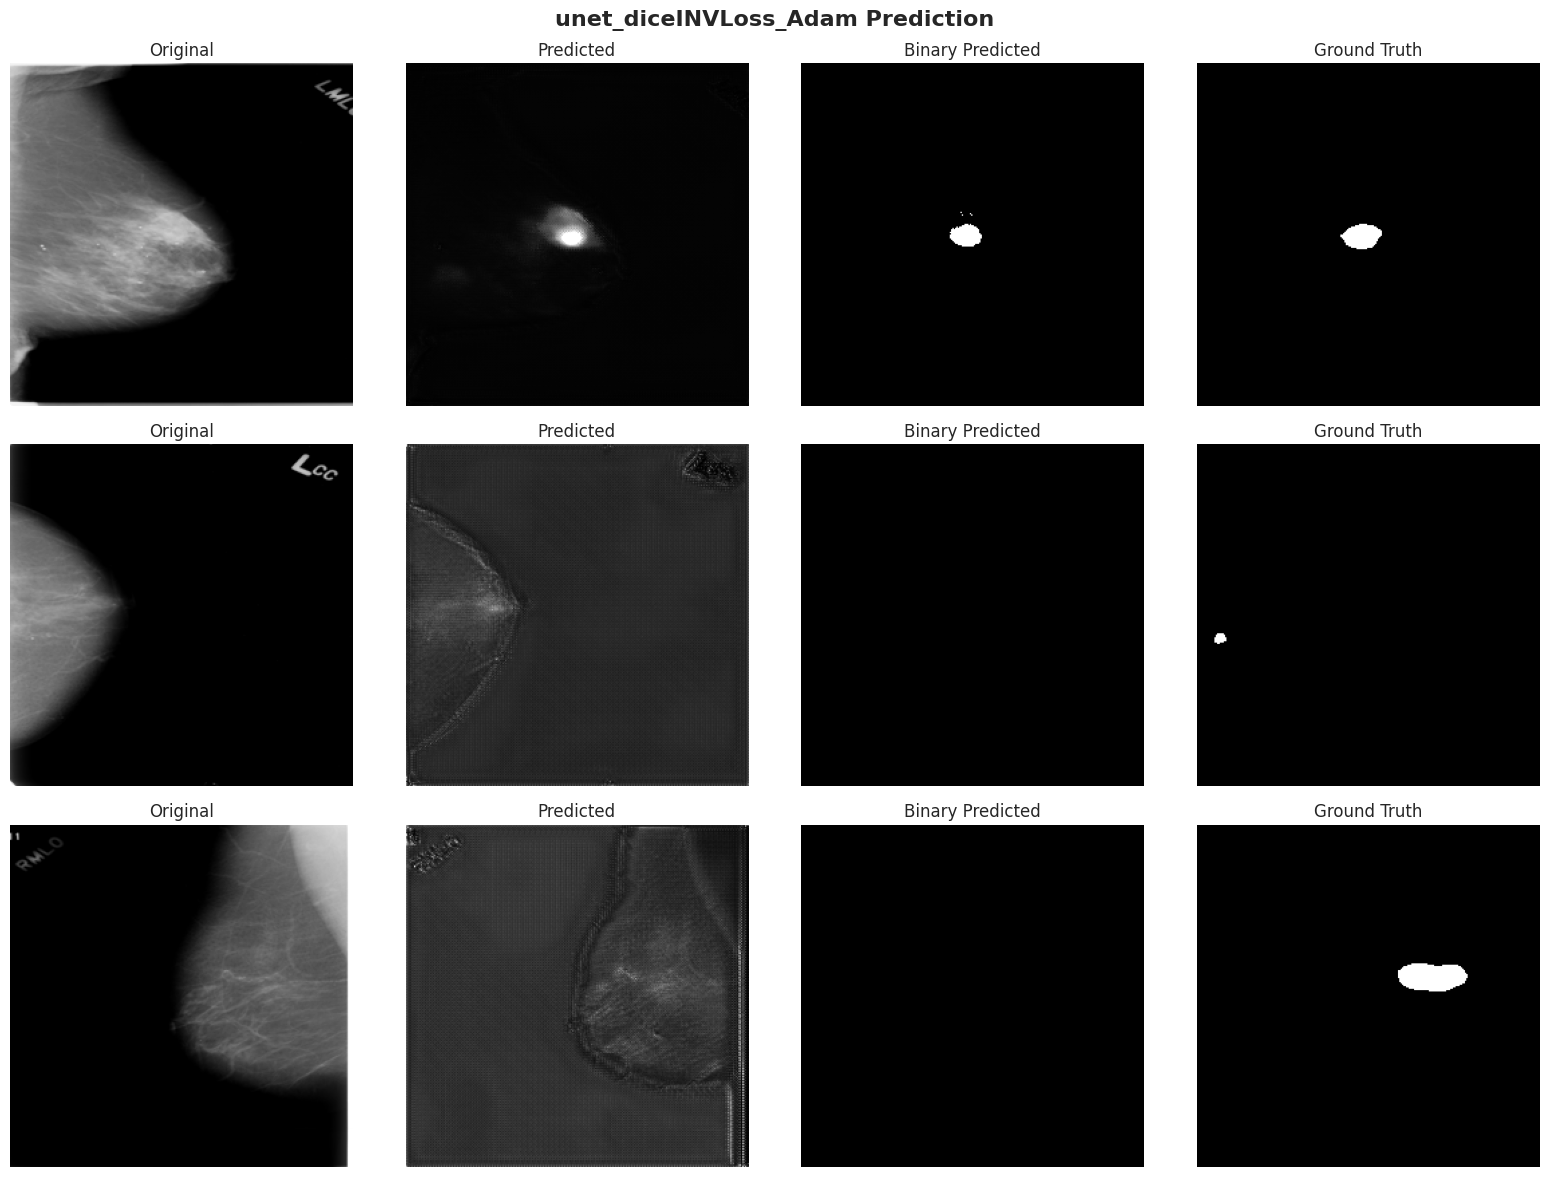

3/3 [==============================] - 1s 114ms/step


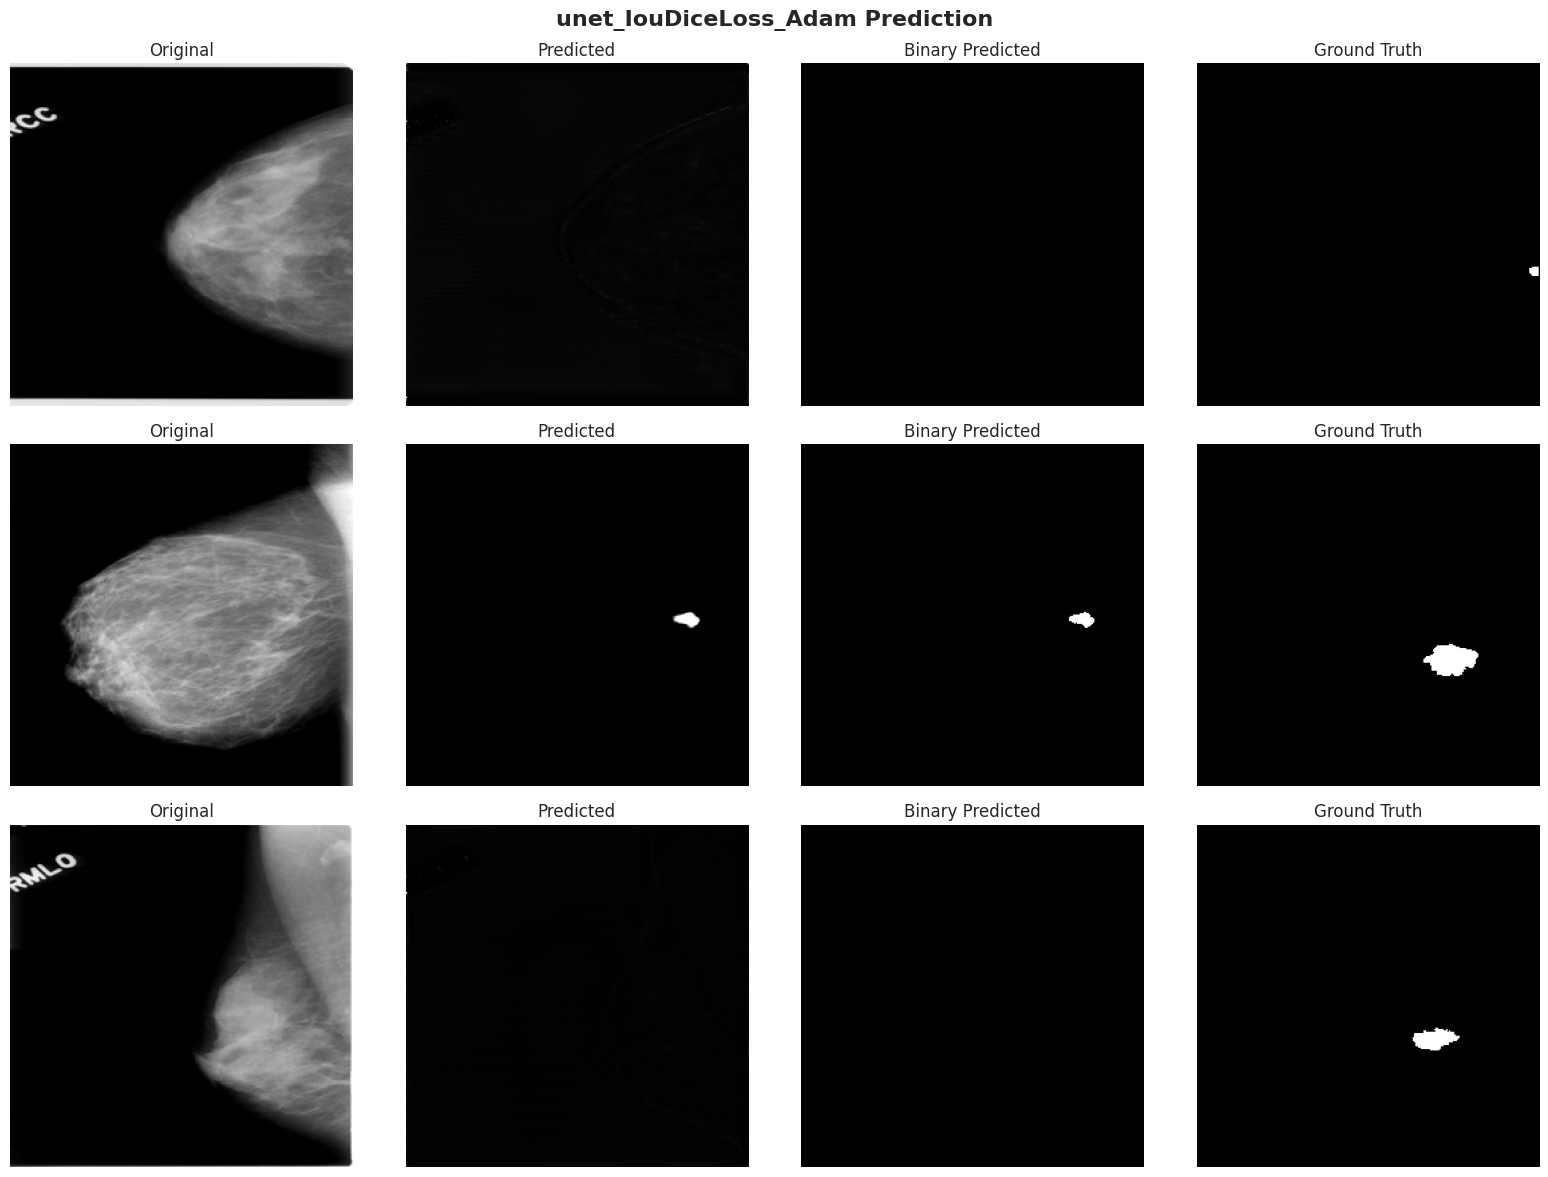

In [56]:
for model_name, model in models.items():
  pred = model.predict(x_test)
  plot_prediction(model_name, pred, x_test)

##different optimizors

In [57]:
optimizers = [Adam_opt(), RMSprop_opt(), SGD_opt()]

In [58]:
x_train , y_train , x_test , y_test , x_val , y_val =  split_data()


In [59]:
histories_opt = {}
models_opt = {}

In [60]:
for opt in optimizers:
        model = unet()
        model.compile(loss=c_loss, optimizer=Adam_opt(), metrics=metrics)
        model_name = 'unet_{}_{}'.format("IOUDice", opt.name)

        print(f'\n #######Training model : {model_name}###########')
        history = model.fit(x_train, y_train,
                            validation_data=(x_test, y_test),
                            callbacks = build_callbacks(model_name),
                            epochs=100,
                            batch_size = 1,
                            verbose=0)
        
        histories_opt[model_name] = history
        models_opt[model_name] = model


 #######Training model : unet_IOUDice_adamOPT###########

Epoch 1: val_loss improved from inf to -0.09061, saving model to /content/drive/MyDrive/trained_models/U-Net/unet_IOUDice_adamOPT.h5

Epoch 2: val_loss improved from -0.09061 to -0.10485, saving model to /content/drive/MyDrive/trained_models/U-Net/unet_IOUDice_adamOPT.h5

Epoch 3: val_loss improved from -0.10485 to -0.13440, saving model to /content/drive/MyDrive/trained_models/U-Net/unet_IOUDice_adamOPT.h5

Epoch 4: val_loss did not improve from -0.13440

Epoch 5: val_loss improved from -0.13440 to -0.13799, saving model to /content/drive/MyDrive/trained_models/U-Net/unet_IOUDice_adamOPT.h5

Epoch 6: val_loss improved from -0.13799 to -0.14532, saving model to /content/drive/MyDrive/trained_models/U-Net/unet_IOUDice_adamOPT.h5

Epoch 7: val_loss did not improve from -0.14532

Epoch 8: val_loss improved from -0.14532 to -0.15458, saving model to /content/drive/MyDrive/trained_models/U-Net/unet_IOUDice_adamOPT.h5

Epoch 9: val_l

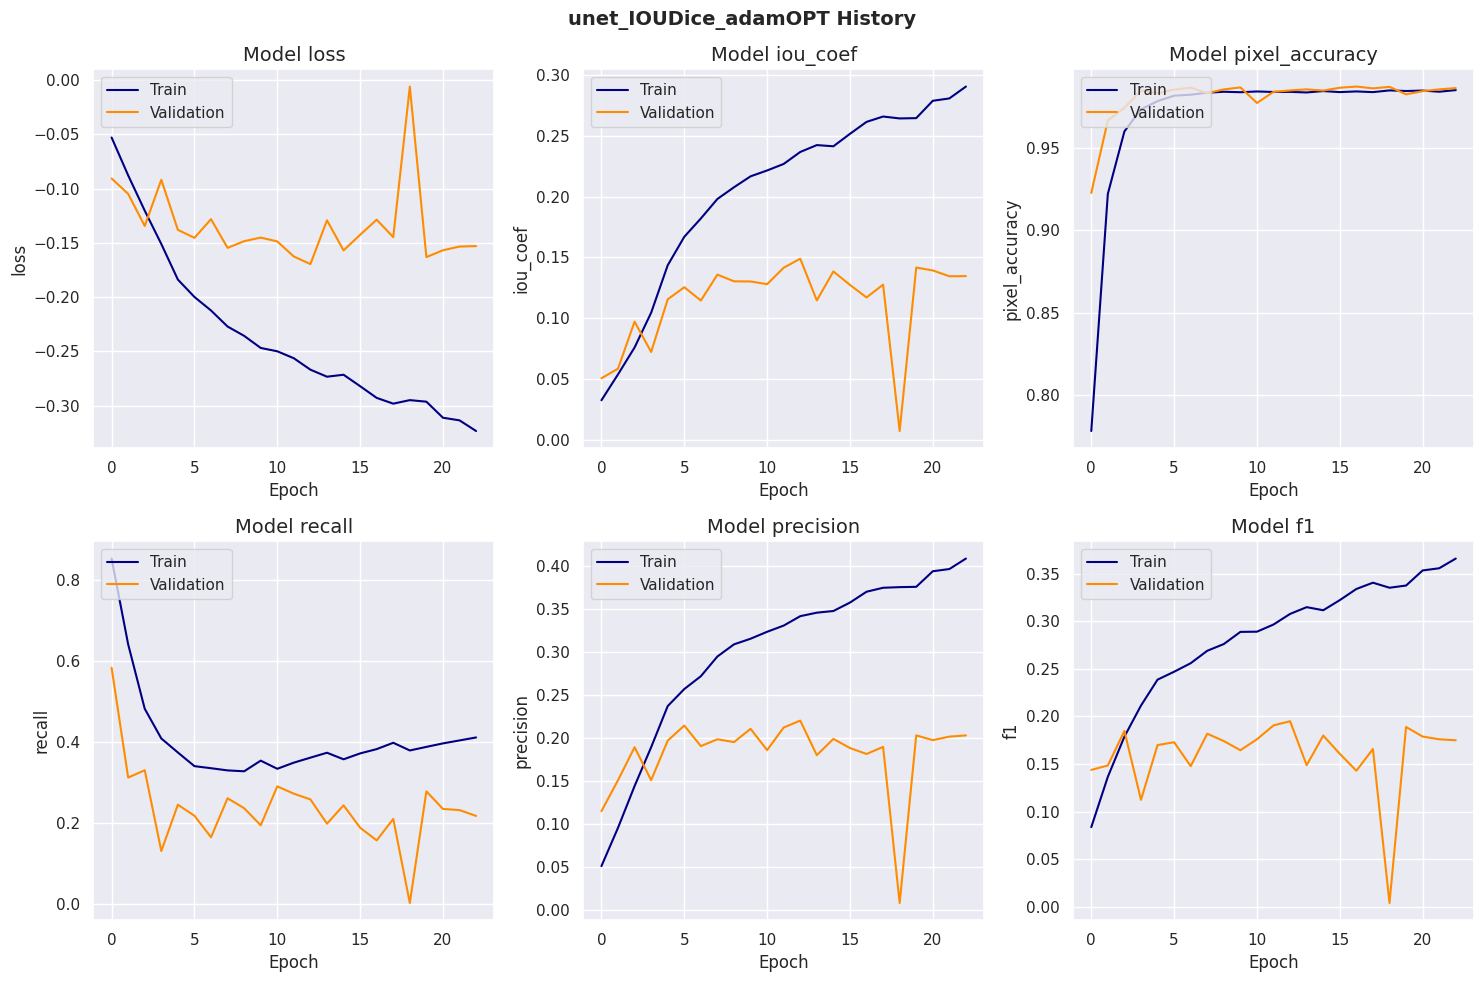

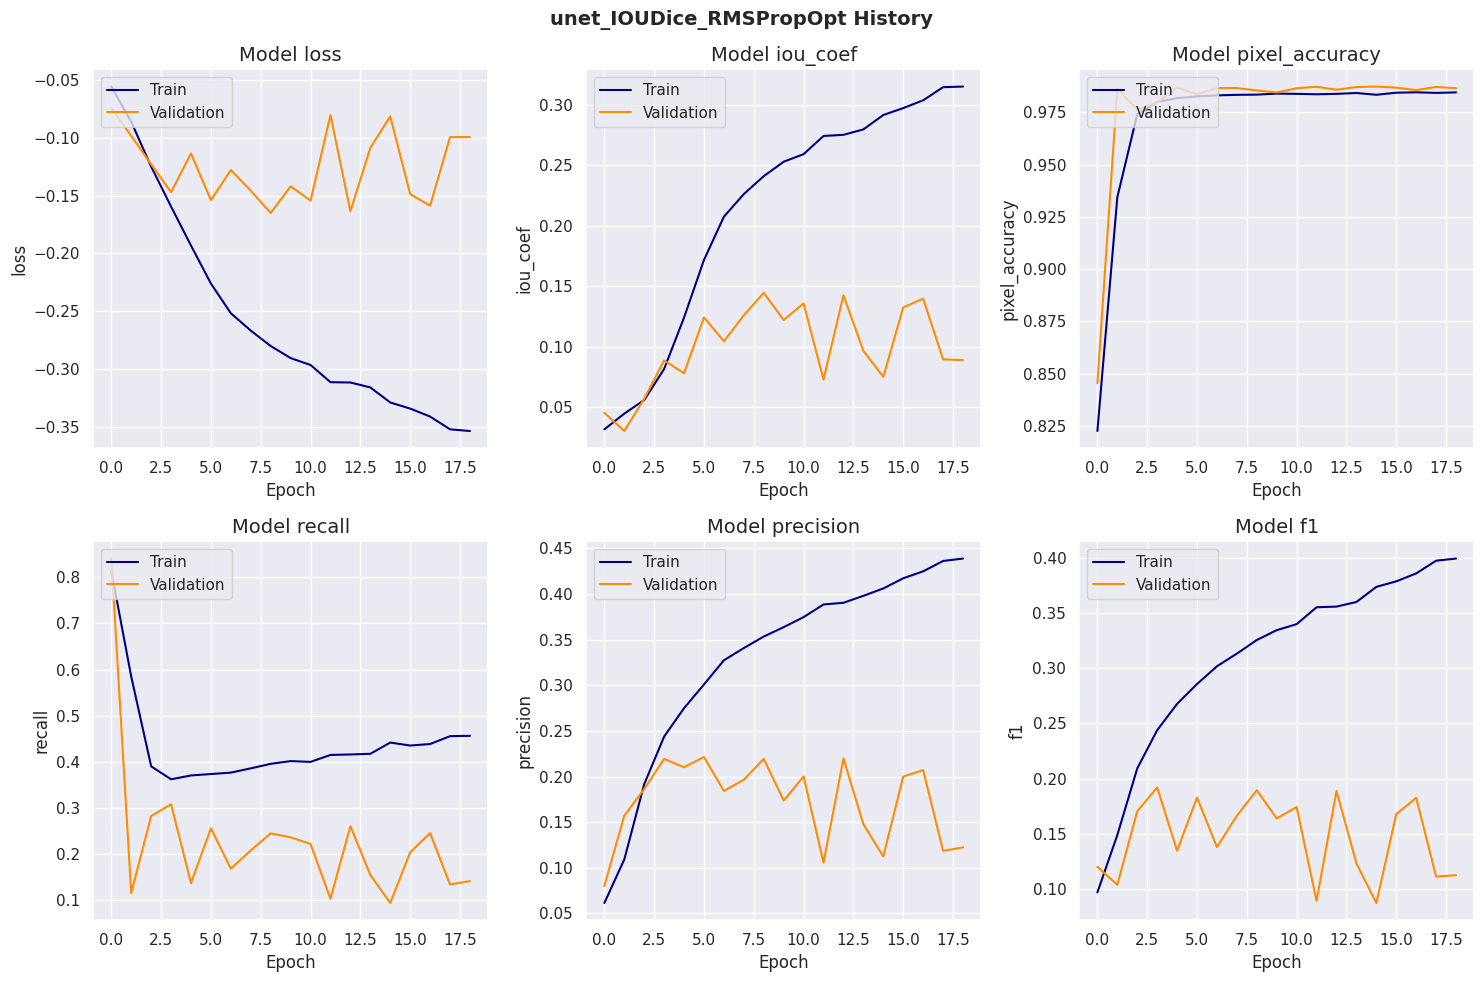

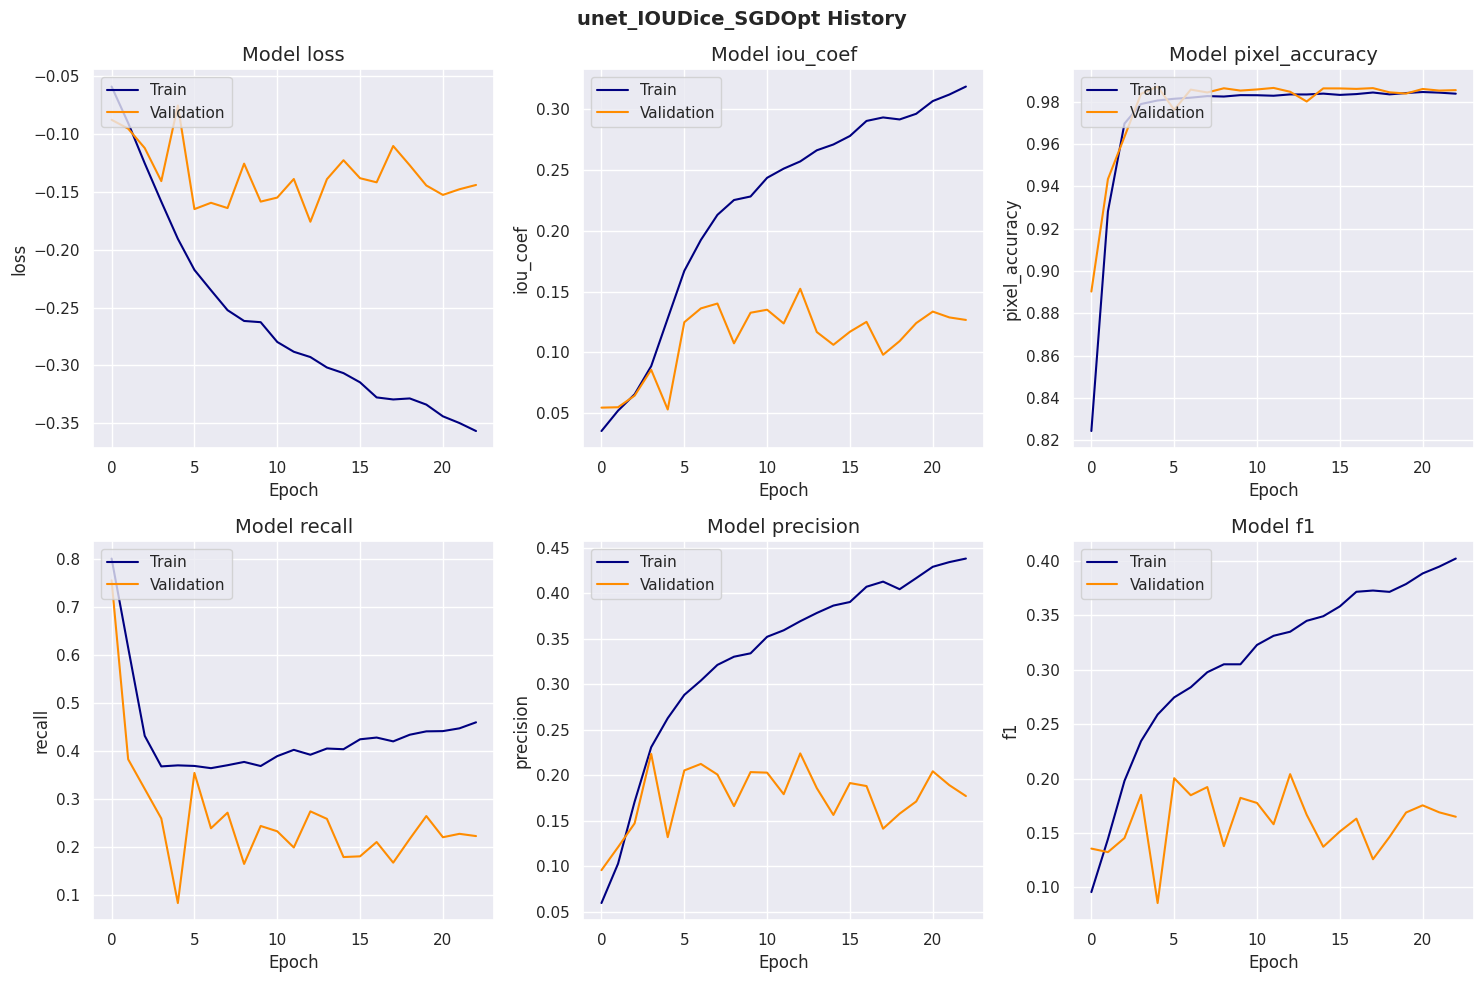

In [61]:
for model_name, history in histories_opt.items():
    print(f'\n \n')
    plot_history(history, model_name)

16/16 [==============================] - 2s 85ms/step


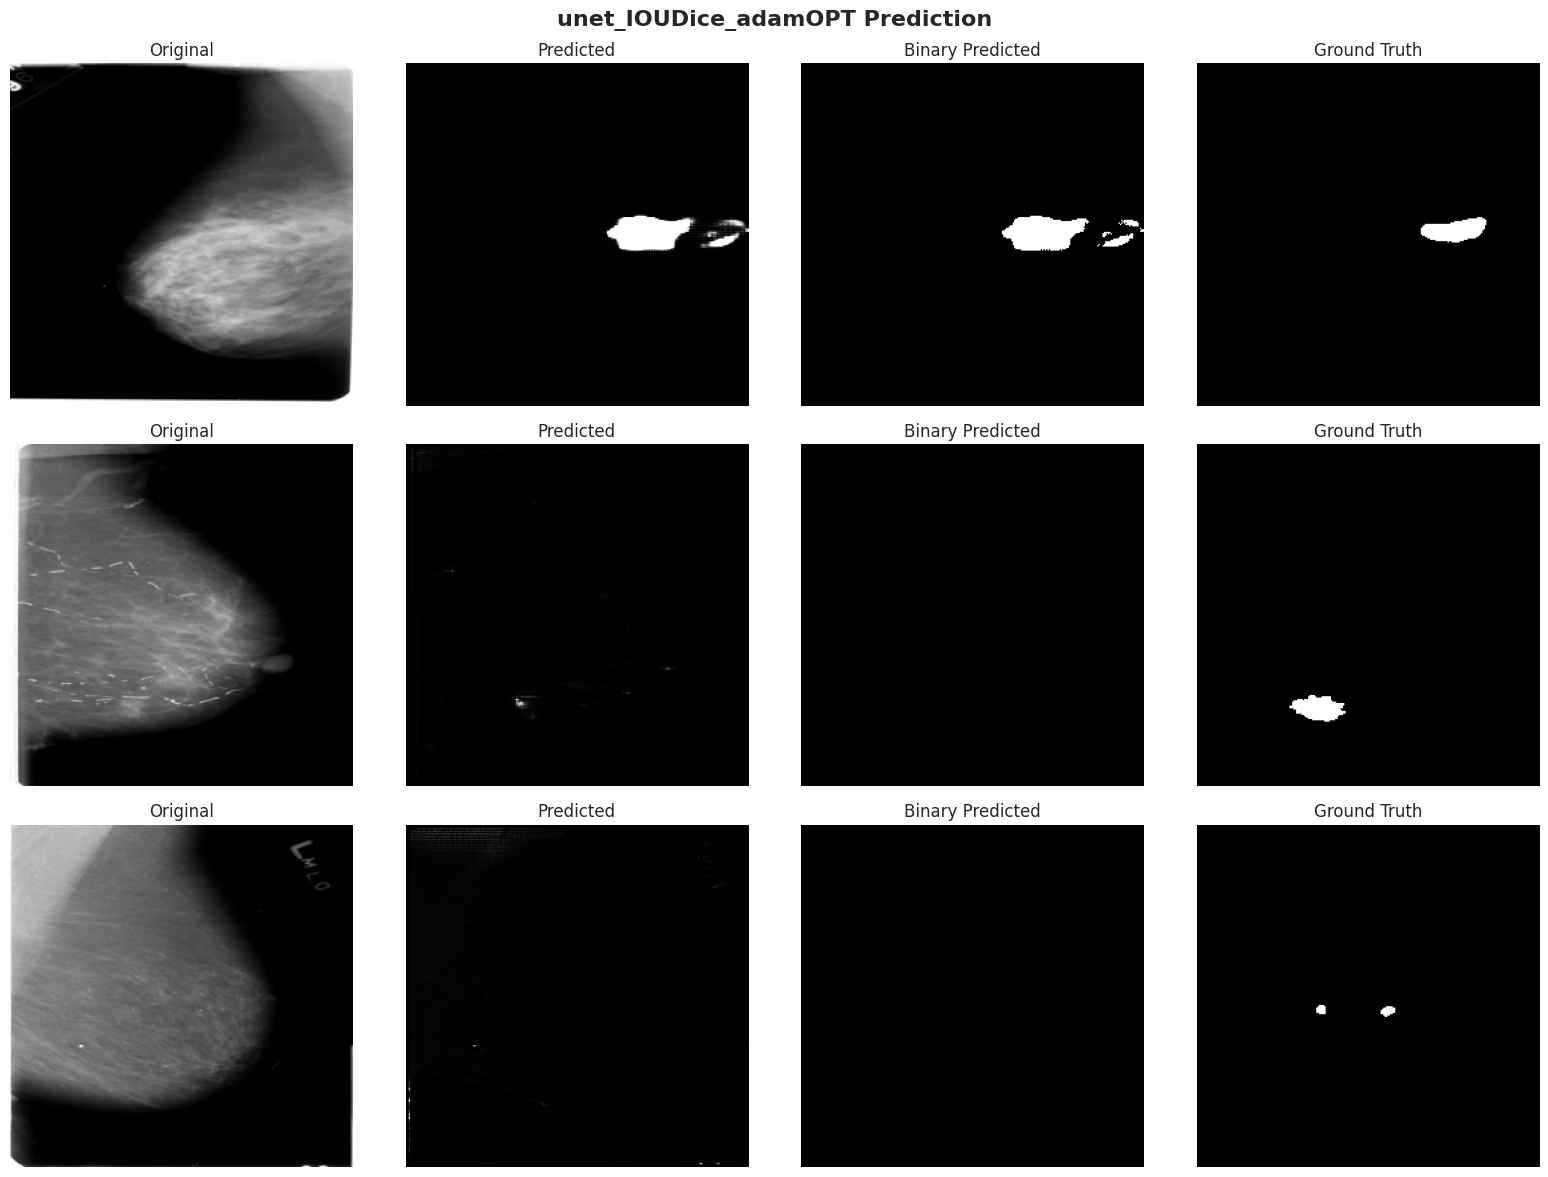


 

16/16 [==============================] - 2s 83ms/step


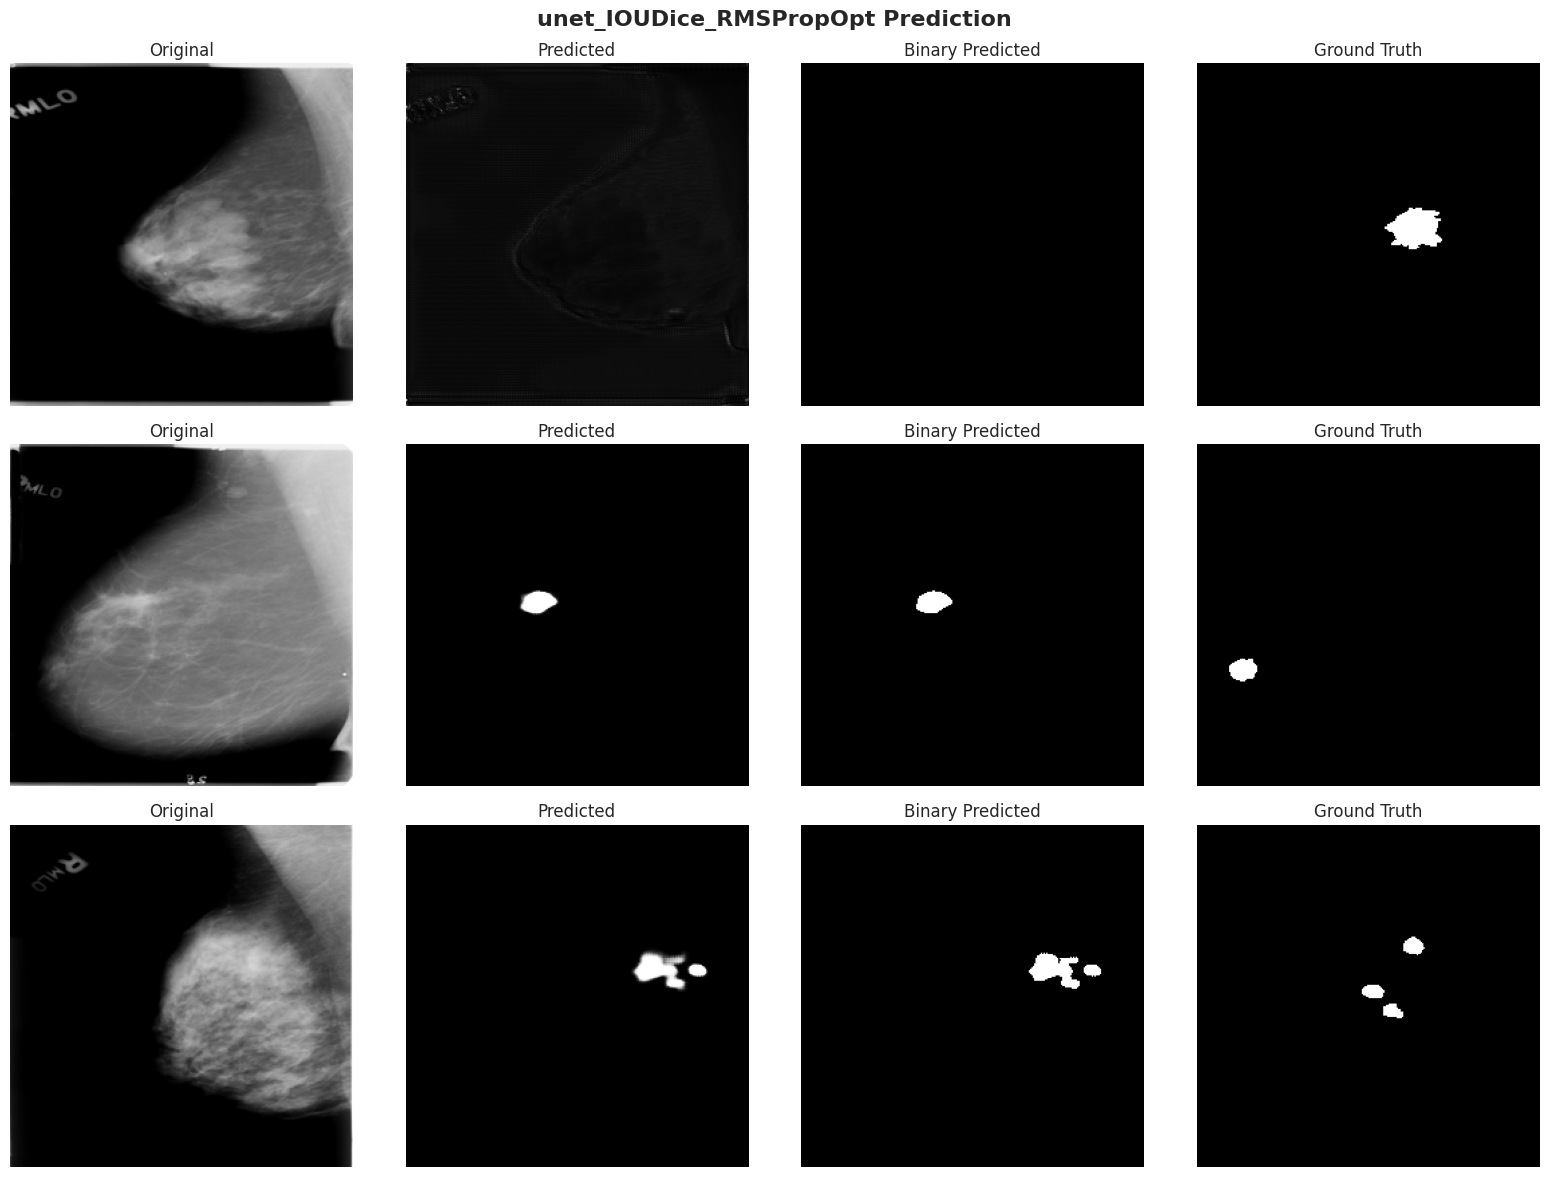


 

16/16 [==============================] - 2s 85ms/step


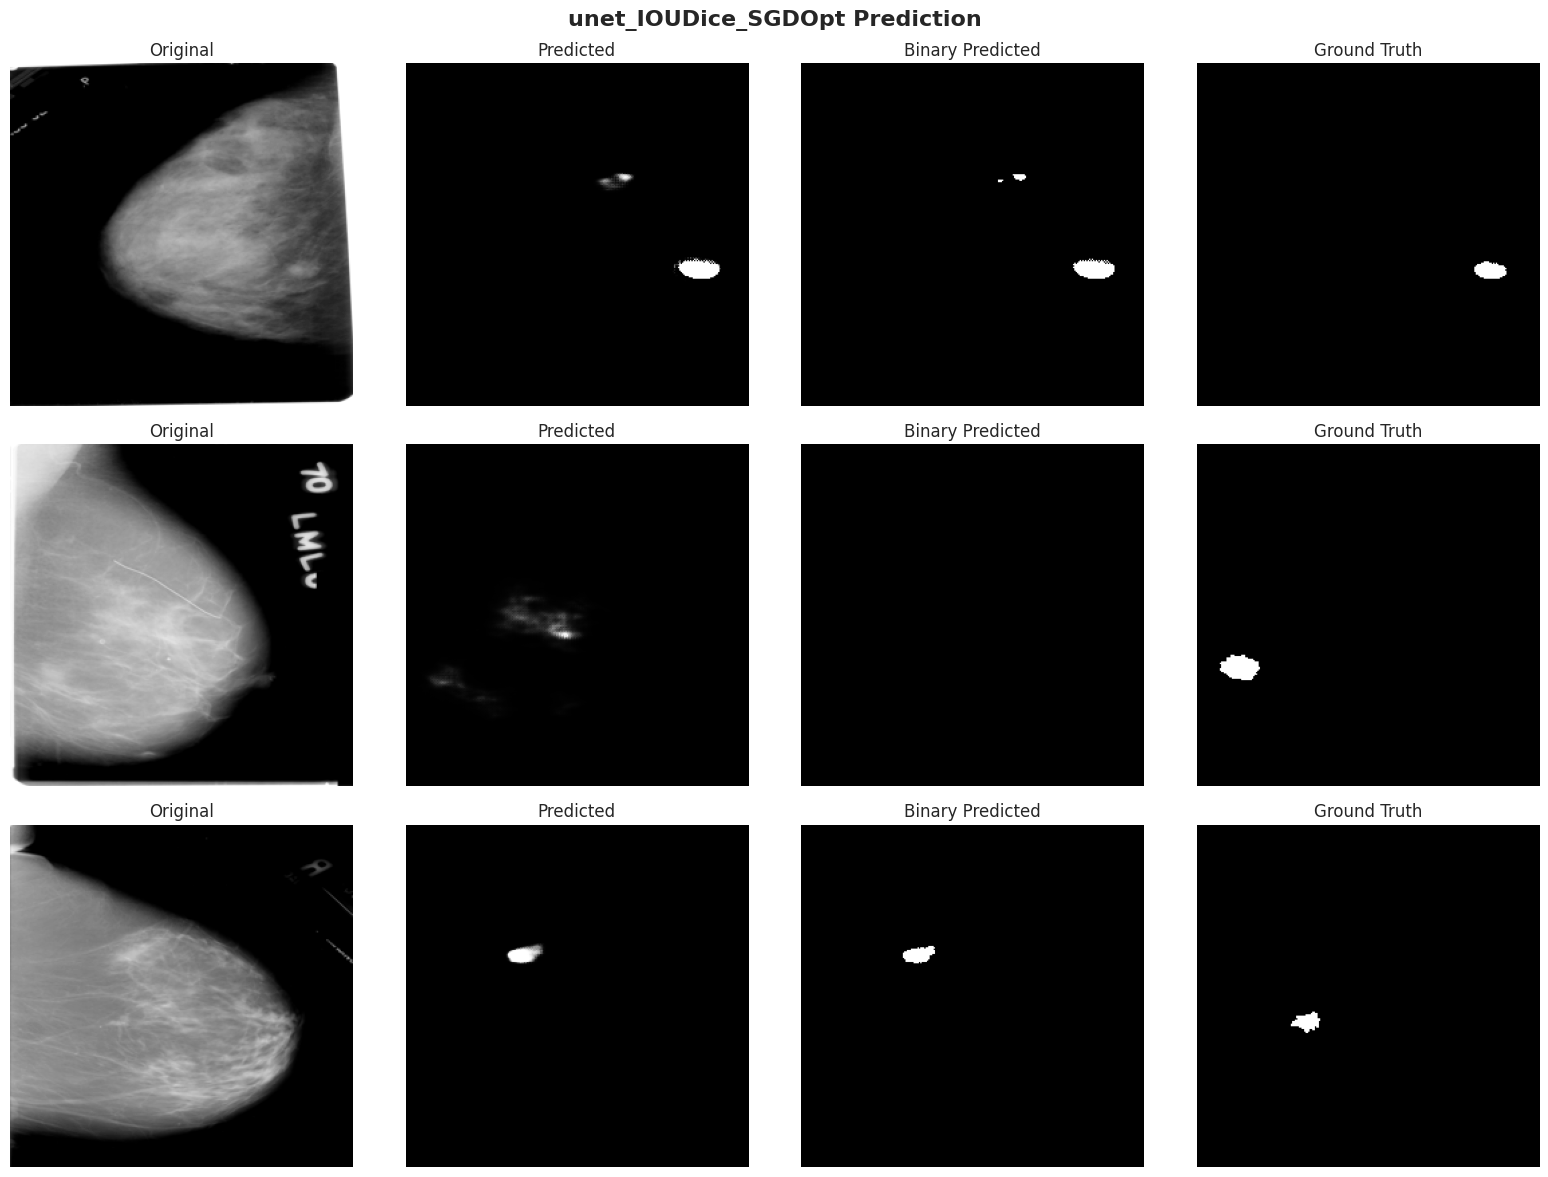

In [62]:
for model_name, model in models_opt.items():
  print(f'\n \n')
  pred = model.predict(x_test)
  plot_prediction(model_name, pred, x_test)

##tuning best optimizor

In [63]:
x_train , y_train , x_test , y_test , x_val , y_val =  split_data()

In [64]:
histories_opt2 = {}
models_opt2 = {}

In [65]:
optimizers = [Adam_opt(0.001) , Adam_opt(0.0001), Adam_opt(lr_schedule())]
opt_names = ["adam_3" , "adam_4", "adam_lr"]

i = 0
for opt in optimizers:
        opt_name = opt_names[i]
        model = unet()
        model.compile(loss=c_loss, optimizer=opt, metrics=metrics)
        model_name = 'unet_{}_{}'.format("IOUDice", opt_name)

        print(f'\n #######Training model : {model_name}###########')

        history = model.fit(x_train, y_train,
                            validation_data=(x_test, y_test),
                            callbacks = build_callbacks(model_name),
                            epochs=100,
                            batch_size = 1,
                            verbose=0)
        
        histories[model_name] = history
        models[model_name] = model
        i = i+1


 #######Training model : unet_IOUDice_adam_3###########

Epoch 1: val_loss improved from inf to -0.08999, saving model to /content/drive/MyDrive/trained_models/U-Net/unet_IOUDice_adam_3.h5

Epoch 2: val_loss did not improve from -0.08999

Epoch 3: val_loss improved from -0.08999 to -0.10292, saving model to /content/drive/MyDrive/trained_models/U-Net/unet_IOUDice_adam_3.h5

Epoch 4: val_loss improved from -0.10292 to -0.13009, saving model to /content/drive/MyDrive/trained_models/U-Net/unet_IOUDice_adam_3.h5

Epoch 5: val_loss improved from -0.13009 to -0.13996, saving model to /content/drive/MyDrive/trained_models/U-Net/unet_IOUDice_adam_3.h5

Epoch 6: val_loss did not improve from -0.13996

Epoch 7: val_loss did not improve from -0.13996

Epoch 8: val_loss did not improve from -0.13996

Epoch 9: val_loss did not improve from -0.13996

Epoch 10: val_loss did not improve from -0.13996

Epoch 11: val_loss did not improve from -0.13996

Epoch 12: val_loss improved from -0.13996 to -0.14

In [66]:
for model_name, history in histories_opt2.items():
    print(f'\n \n')
    plot_history(history, model_name)

In [67]:
for model_name, model in models_opt2.items():
  print(f'\n \n')
  pred = model.predict(x_test)
  plot_prediction(model_name, pred, x_test)

##Training best model

**test split 0.2**


 #######Training model : unet_best_IOUDice_test0.2_adam###########
Epoch 1/100
1940/1940 [==============================] - ETA: 0s - loss: -0.0895 - iou_coef: 0.0561 - pixel_accuracy: 0.9238 - recall: 0.4195 - precision: 0.1067 - f1: 0.1224
Epoch 1: val_loss improved from inf to -0.10591, saving model to /content/drive/MyDrive/trained_models/U-Net/unet_best_IOUDice_test0.2_adam.h5
1940/1940 [==============================] - 61s 23ms/step - loss: -0.0895 - iou_coef: 0.0561 - pixel_accuracy: 0.9238 - recall: 0.4195 - precision: 0.1067 - f1: 0.1224 - val_loss: -0.1059 - val_iou_coef: 0.0675 - val_pixel_accuracy: 0.9747 - val_recall: 0.2140 - val_precision: 0.1578 - val_f1: 0.1222
Epoch 2/100
1938/1940 [============================>.] - ETA: 0s - loss: -0.1328 - iou_coef: 0.1024 - pixel_accuracy: 0.9738 - recall: 0.2822 - precision: 0.1661 - f1: 0.1652
Epoch 2: val_loss did not improve from -0.10591
1940/1940 [==============================] - 42s 22ms/step - loss: -0.1326 - iou_coef: 0

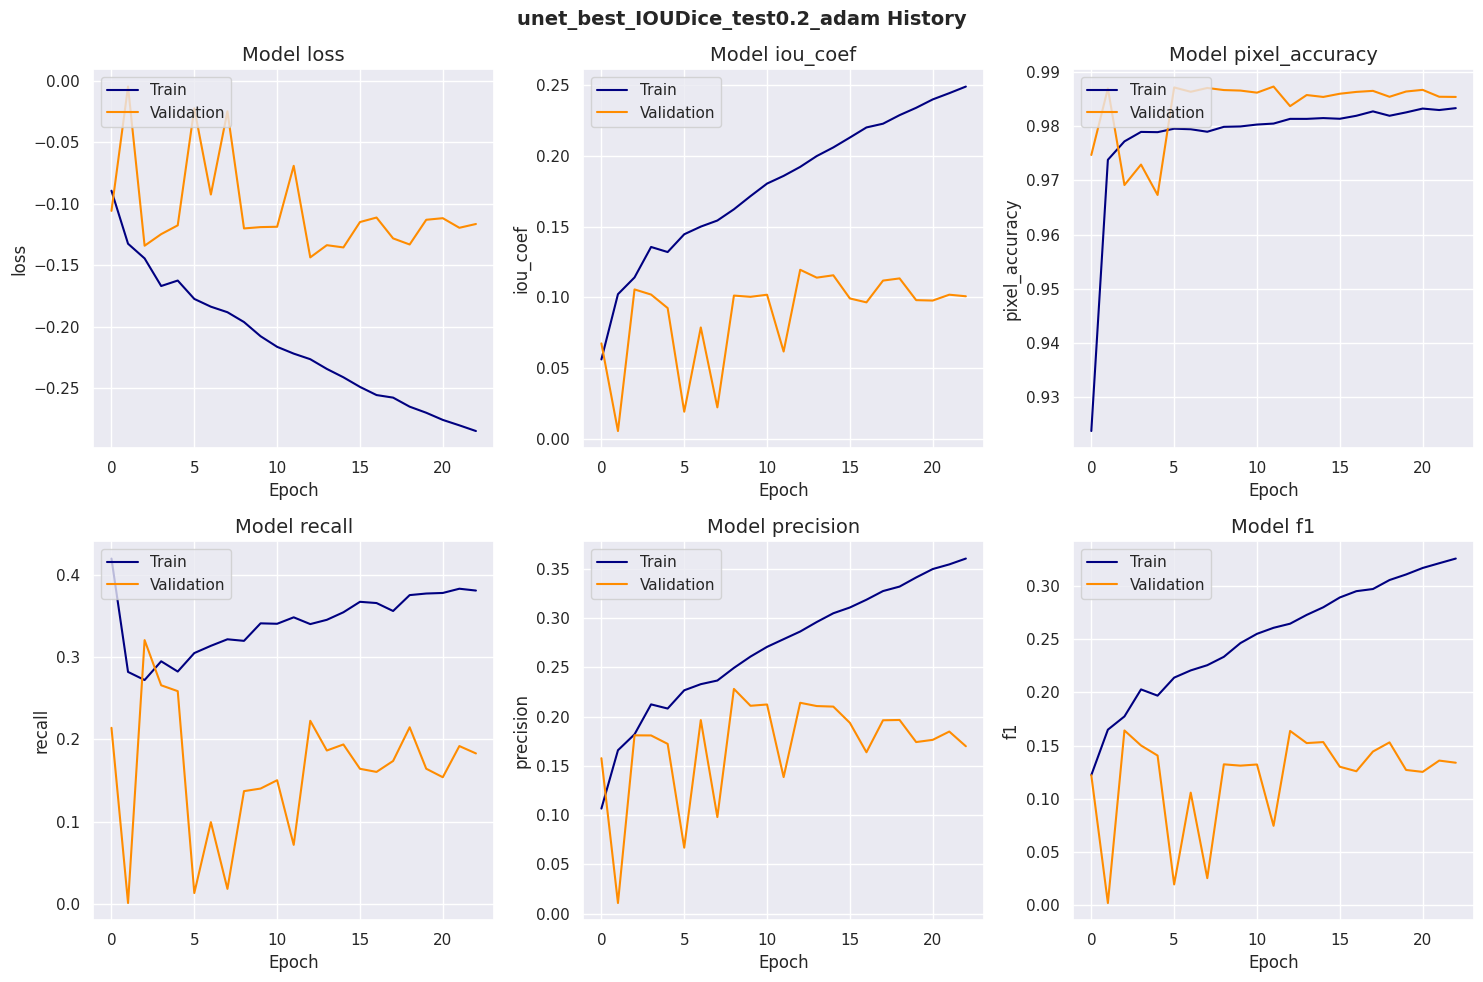

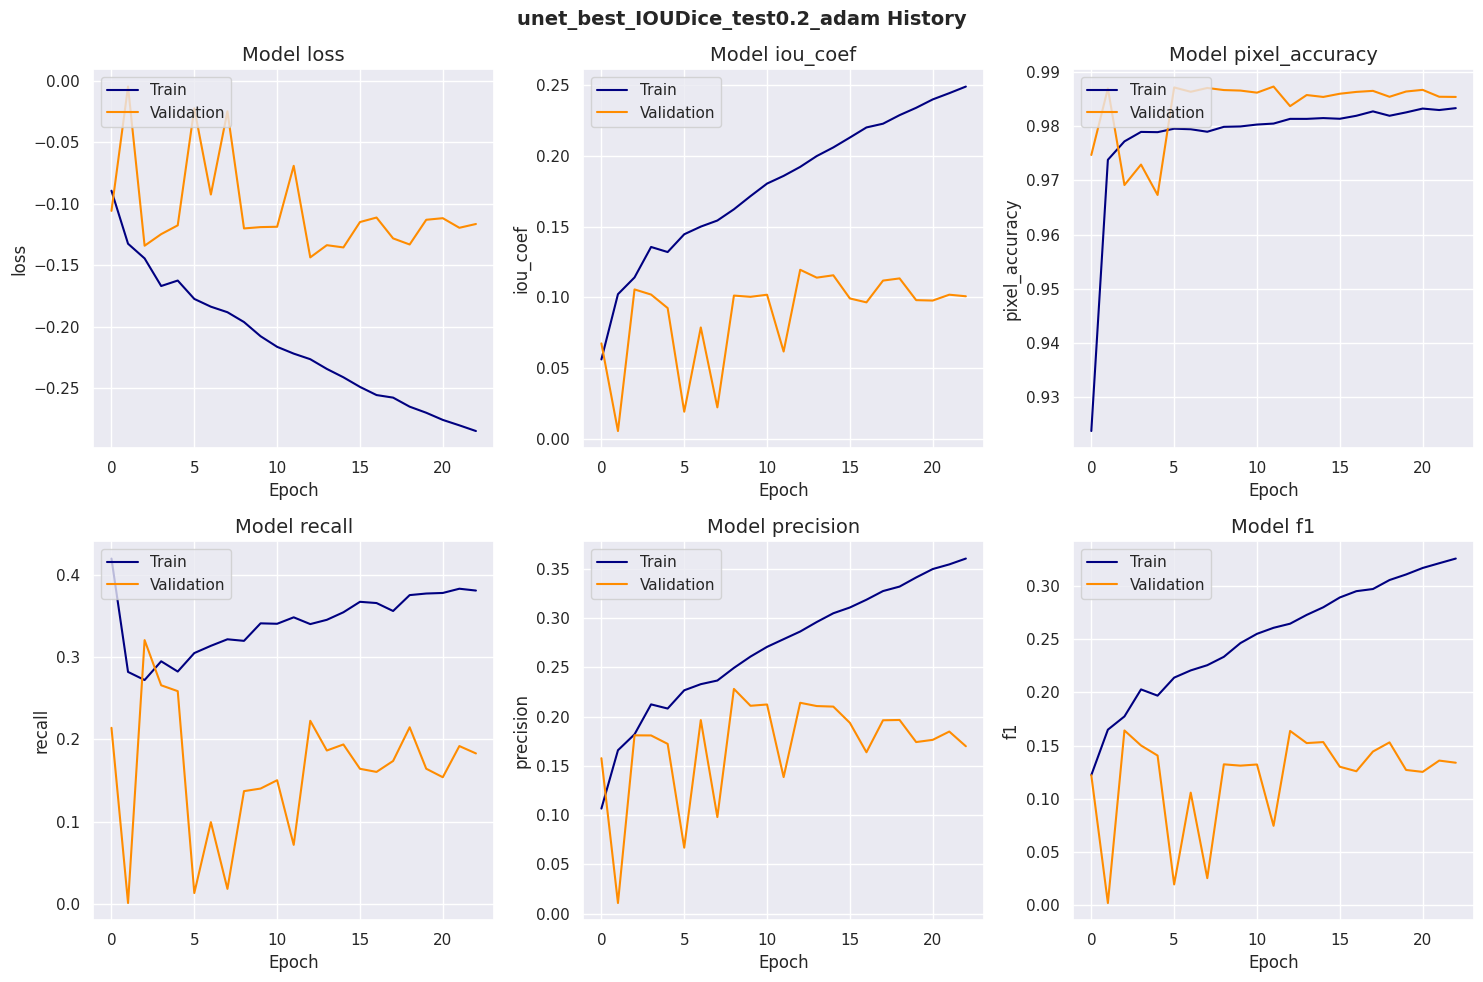

In [68]:
x_train , y_train , x_test , y_test , x_val , y_val =  split_data(test_size = 0.2 , val_size = 0.2)

model = unet()
model.compile(loss=c_loss, optimizer=Adam_opt(lr_schedule()), metrics=metrics)
model_name = 'unet_{}_{}'.format("best_IOUDice_test0.2", "adam")

print(f'\n #######Training model : {model_name}###########')

history = model.fit(x_train, y_train,
                            validation_data=(x_test, y_test),
                            callbacks = build_callbacks(model_name),
                            epochs=100,
                            batch_size = 1,
                            verbose=1)

print(f'\n \n')
plot_history(history, model_name)

print(f'\n \n')
plot_history(history, model_name)

**test split 0.1**


 #######Training model : unet_best_IOUDice_test0.1_adam###########

Epoch 1: val_loss improved from inf to -0.10745, saving model to /content/drive/MyDrive/trained_models/U-Net/unet_best_IOUDice_test0.1_adam.h5

Epoch 2: val_loss did not improve from -0.10745

Epoch 3: val_loss did not improve from -0.10745

Epoch 4: val_loss improved from -0.10745 to -0.13224, saving model to /content/drive/MyDrive/trained_models/U-Net/unet_best_IOUDice_test0.1_adam.h5

Epoch 5: val_loss did not improve from -0.13224

Epoch 6: val_loss improved from -0.13224 to -0.13504, saving model to /content/drive/MyDrive/trained_models/U-Net/unet_best_IOUDice_test0.1_adam.h5

Epoch 7: val_loss did not improve from -0.13504

Epoch 8: val_loss improved from -0.13504 to -0.16110, saving model to /content/drive/MyDrive/trained_models/U-Net/unet_best_IOUDice_test0.1_adam.h5

Epoch 9: val_loss did not improve from -0.16110

Epoch 10: val_loss did not improve from -0.16110

Epoch 11: val_loss did not improve from -0.16

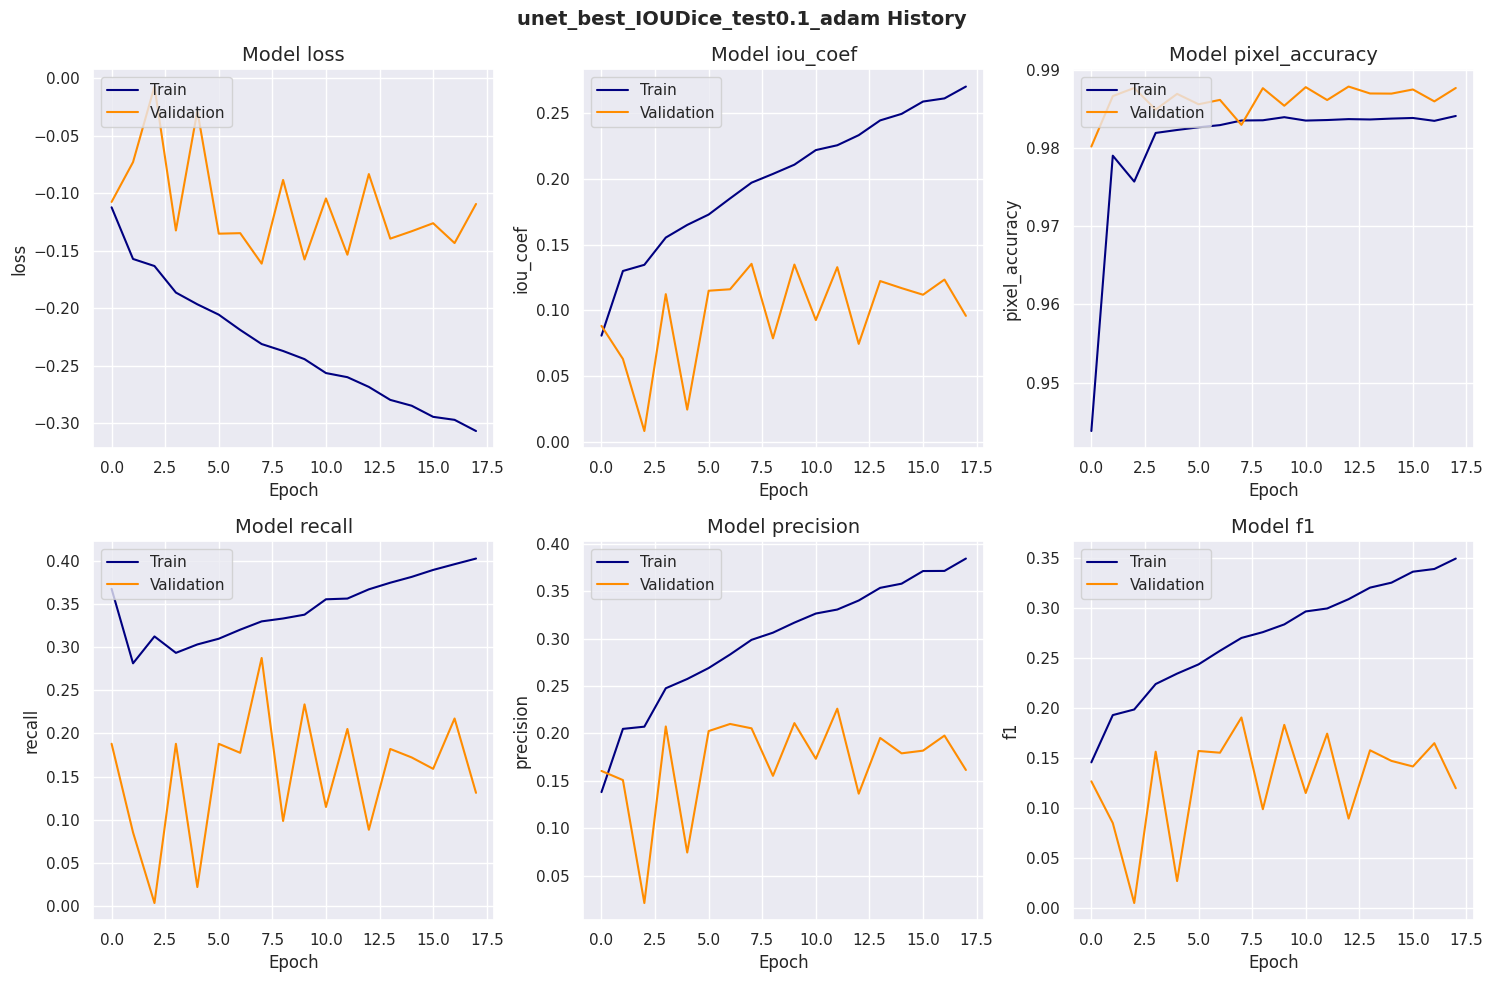

18/18 [==============================] - 3s 127ms/step


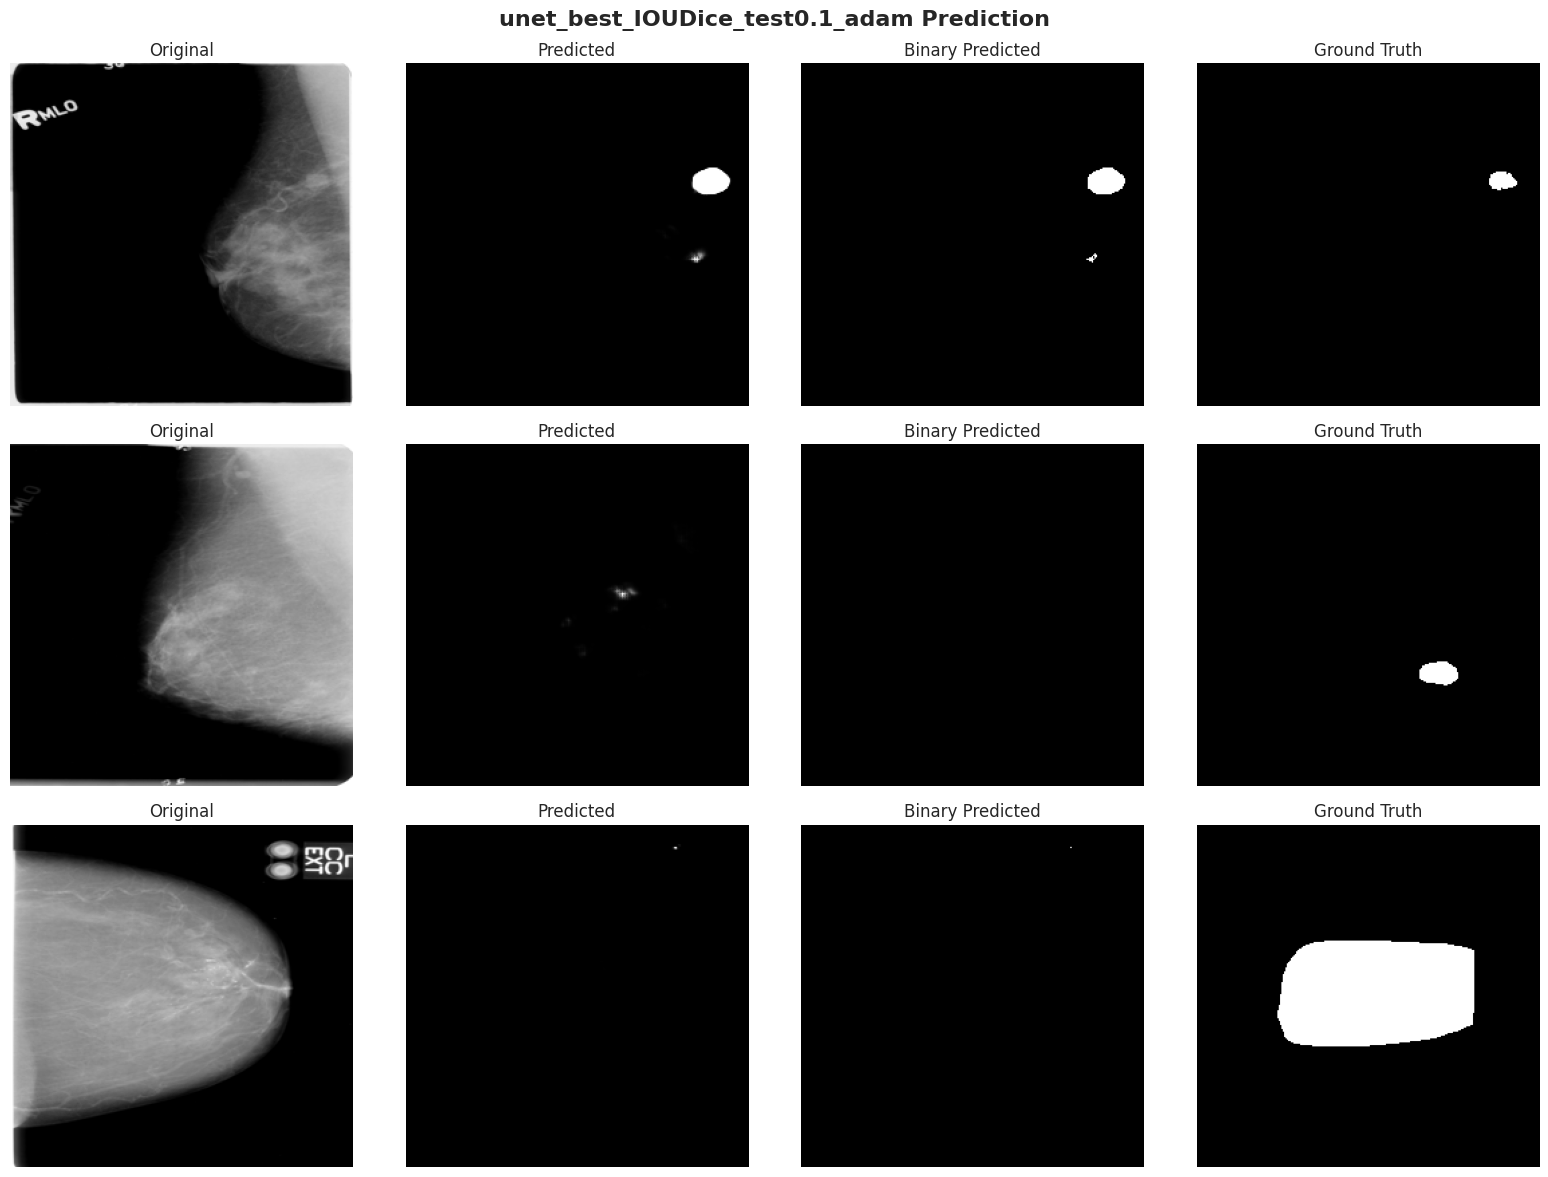

In [69]:
x_train , y_train , x_test , y_test , x_val , y_val =  split_data(test_size = 0.1 , val_size = 0.2)

model = unet()
model.compile(loss=c_loss, optimizer=Adam_opt(lr_schedule()), metrics=metrics)
model_name = 'unet_{}_{}'.format("best_IOUDice_test0.1", "adam")

print(f'\n #######Training model : {model_name}###########')

history = model.fit(x_train, y_train,
                            validation_data=(x_test, y_test),
                            callbacks = build_callbacks(model_name),
                            epochs=100,
                            batch_size = 1,
                            verbose=0)

print(f'\n \n')
plot_history(history, model_name)

pred = model.predict(x_test)
plot_prediction(model_name, pred, x_test)

**test split 0.1 val 0.1**



 #######Training model : unet_best_IOUDice_test0.1_val0.05_adam###########

Epoch 1: val_loss improved from inf to -0.01722, saving model to /content/drive/MyDrive/trained_models/U-Net/unet_best_IOUDice_test0.1_val0.05_adam.h5

Epoch 2: val_loss improved from -0.01722 to -0.07285, saving model to /content/drive/MyDrive/trained_models/U-Net/unet_best_IOUDice_test0.1_val0.05_adam.h5

Epoch 3: val_loss did not improve from -0.07285

Epoch 4: val_loss improved from -0.07285 to -0.13770, saving model to /content/drive/MyDrive/trained_models/U-Net/unet_best_IOUDice_test0.1_val0.05_adam.h5

Epoch 5: val_loss did not improve from -0.13770

Epoch 6: val_loss did not improve from -0.13770

Epoch 7: val_loss did not improve from -0.13770

Epoch 8: val_loss did not improve from -0.13770

Epoch 9: val_loss did not improve from -0.13770

Epoch 10: val_loss did not improve from -0.13770

Epoch 11: val_loss did not improve from -0.13770

Epoch 12: val_loss did not improve from -0.13770

Epoch 13: val

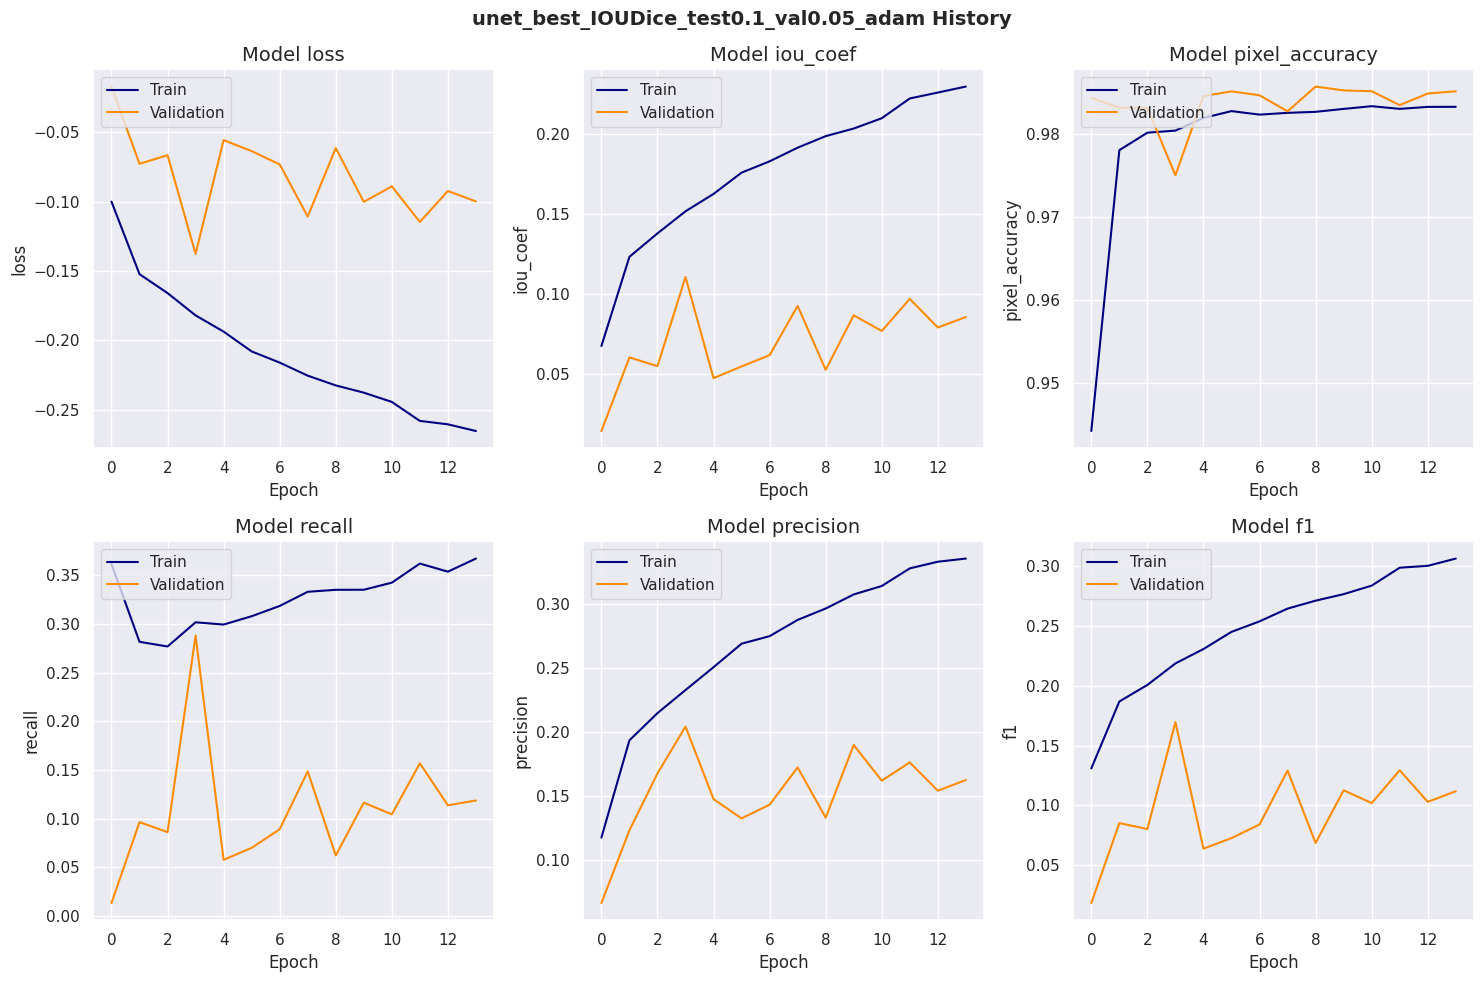

5/5 [==============================] - 2s 463ms/step


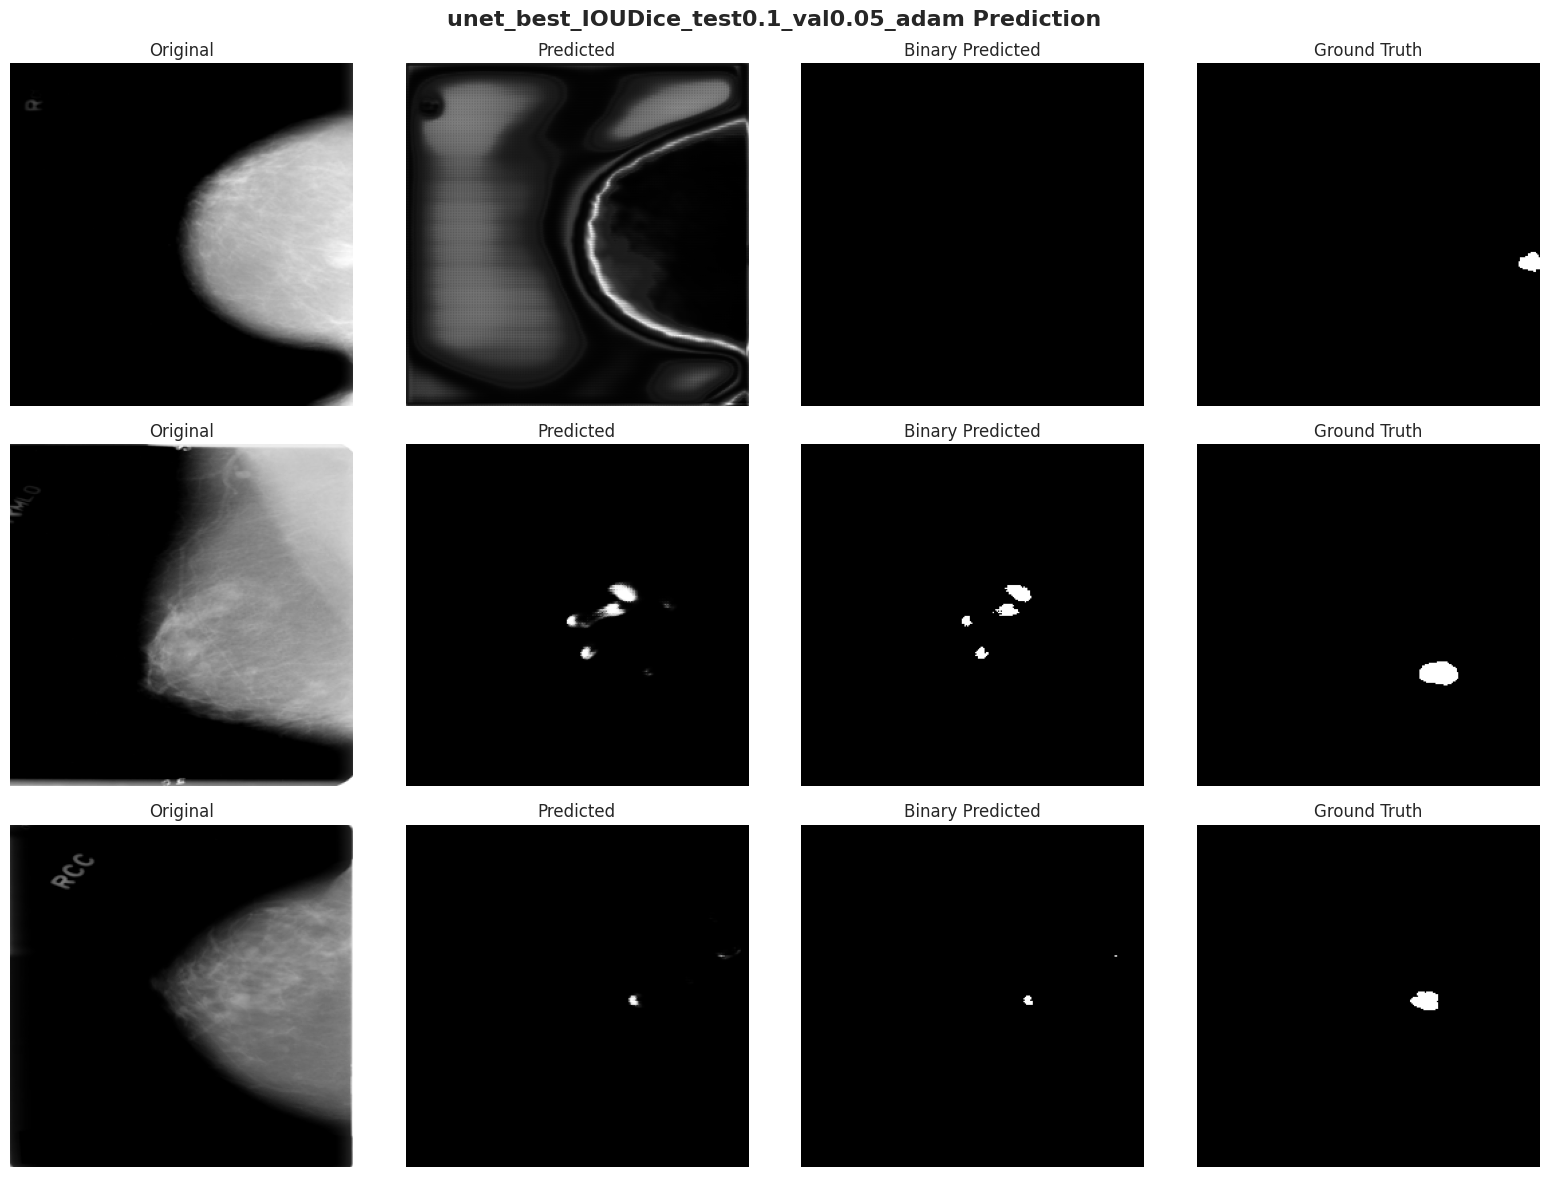

In [70]:
x_train , y_train , x_test , y_test , x_val , y_val =  split_data(test_size = 0.1 , val_size = 0.05)

model = unet()
model.compile(loss=c_loss, optimizer=Adam_opt(lr_schedule()), metrics=metrics)
model_name = 'unet_{}_{}'.format("best_IOUDice_test0.1_val0.05", "adam")

print(f'\n #######Training model : {model_name}###########')

history = model.fit(x_train, y_train,
                            validation_data=(x_test, y_test),
                            callbacks = build_callbacks(model_name),
                            epochs=100,
                            batch_size = 1,
                            verbose=0)

print(f'\n \n')
plot_history(history, model_name)

pred = model.predict(x_test)
plot_prediction(model_name, pred, x_test)